# Анализ убытков развлекательного приложения #

## Описание проекта ##

Данное исследование - анализ проблем с окупаемостью развлекательного приложения Procrastinate Pro+.        
**Описание проблемы:**    
Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача данноего исследования — разобраться в причинах и помочь компании выйти в плюс.

В нашем распоряжении есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Нам предстоит изучить:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.





## Описание данных##

В вашем распоряжении три датасета.     Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:

- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv:

- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info_short.csv:

- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

## Подготовка данных к анализу ##

In [ ]:
# импортируем необходимые библиотеки
import pandas as pd
from datetime import datetime
from datetime import date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Сохраним данные из файлов c информацией о визитах, покупках и рекламных расходах
# в переменные visits, orders, costs
try:
    visits, orders, costs = (
                            pd.read_csv('./content/drive/MyDrive/Datasets/visits_info_short.csv'),
                            pd.read_csv('./content/drive/MyDrive/Datasets/orders_info_short.csv'),
                            pd.read_csv('./content/drive/MyDrive/Datasets/costs_info_short.csv')
                            )
except:
    visits, orders, costs = (
                            pd.read_csv('/content/drive/MyDrive/Datasets/visits_info_short.csv'),
                            pd.read_csv('/content/drive/MyDrive/Datasets/orders_info_short.csv'),
                            pd.read_csv('/content/drive/MyDrive/Datasets/costs_info_short.csv')
                            )

In [ ]:
# зададим функцию для предобработки данных
def preprocessing(dataset):
    dataset.columns = [x.lower().replace(' ', '_') for x in dataset.columns]
    print(dataset.head())
    print()
    print(dataset.info())
    print()
    print(dataset.isna().sum())
    print()
    if dataset.duplicated().sum() == 0:
        print('Явных дубликатов не обнаружено')
    else:
        print(dataset.duplicated().sum())

In [ ]:
preprocessing(visits)

        user_id         region   device  channel        session_start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           session_end  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null 

In [ ]:
# Проверим, нет ли дублирующихся названий регионов
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

Неявных дубликатов в названиях регионов нет

In [ ]:
# Приведем данные содержащие даты к формату datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [ ]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Проделаем те же действия по предобработке с остальными датасетами.

In [ ]:
preprocessing(orders)

        user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

user_id     0
event_dt    0
revenue     0
dtype: int64

Явных дубликатов не обнаружено


In [ ]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [ ]:
preprocessing(costs)

           dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None

dt         0
channel    0
costs      0
dtype: int64

Явных дубликатов не обнаружено


In [ ]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [ ]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


In [ ]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

## Вывод ##

Мы выполнили предобработку данных:
- Сохранили данные о посещениях, продажах и затратах в переменные visits, orders, costs.
- Привели названия столбцов к нижнему регистру.
- Проверили данные на наличие явных и неявных дубликатов и пропусков.
- Дубликаты и пропуски в таблицах отсутствуют.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии. ##

Зададим функции, для расчета необходимых метрик и построения графиков.

### Функция для построения пользовательских профилей ###

In [ ]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для рассчёта удержания ###

In [ ]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчёта конверсии ###

In [ ]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )


    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days


    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)


    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчета LTV и ROI ###

In [ ]:
def get_ltv(
    profiles,  # Шаг 1. Получить профили и данные о покупках
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Добавить данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 3. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Шаг 4. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 5. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 6. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 7. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        # сохраняем в датафрейм данные пользователей и значения CAC,
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция для сглаживания фрейма ###

In [ ]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

### Функция для построения графика Retention Rate ###

In [ ]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    plt.tight_layout()
    plt.show()

### Функция для построения графика конверсии ###

In [ ]:
# Визуализация конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция для визуализации LTV и ROI ###

In [ ]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(15, 20))
    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(3, 2, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 2, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(3, 2, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных ##

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Выясним, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

### Профили пользователей ###

In [ ]:
profiles = get_profiles(visits, orders, costs)

In [ ]:
profiles.head()

user_id            first_ts     channel  device         region         dt  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States 2019-05-07   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States 2019-07-09   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France 2019-10-01   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany 2019-08-22   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States 2019-10-02   

                month  payer  acquisition_cost  
0 2019-05-07 20:58:57   True          1.088172  
1 2019-07-09 12:46:07  False          1.107237  
2 2019-10-01 09:58:33  False          0.000000  
3 2019-08-22 21:35:48  False          0.988235  
4 2019-10-02 00:07:44  False          0.230769

**Определим минимальную и максимальную даты привлечения пользователей.**

In [ ]:
profiles['dt'].min()

Timestamp('2019-05-01 00:00:00')

In [ ]:
profiles['dt'].max()

Timestamp('2019-10-27 00:00:00')

Мы получили 150008 профилей пользователей. Данные содержат уникальный идентификационный номер пользователя, дату и месяц первого посещения сайта, канал привлечения, устройство, признак плательщика и средние расходы на привлечение одного пользователя.

Минимальная дата привлечения пользователей - 1 мая 2019 года.    
Максимальная дата привлечения пользователей - 27 октября 2019 года.

### Анализ пользовательских профилей с делением по странам ###

**Выясним, из каких стран пользователи приходят в приложение
и на какую страну приходится больше всего платящих пользователей.**

In [ ]:
# сгруппируем профили по регионам, посчитаем количество пользователей,
# количество платящих пользователей и процент их распределения по регионам
profiles_region = (
    profiles.groupby('region')[['user_id', 'payer']]
    .agg({'user_id': 'count', 'payer':'sum'}).reset_index()
)
profiles_region['users_percent'] = round(profiles_region['user_id'] / profiles_region['user_id'].sum() *100, 1)
profiles_region['payers_percent'] = round(profiles_region['payer'] / profiles_region['user_id'] *100, 1)
profiles_region.sort_values(by='payer', ascending=False)

region  user_id  payer  users_percent  payers_percent
3  United States   100002   6902           66.7             6.9
2             UK    17575    700           11.7             4.0
0         France    17450    663           11.6             3.8
1        Germany    14981    616           10.0             4.1

**Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.**

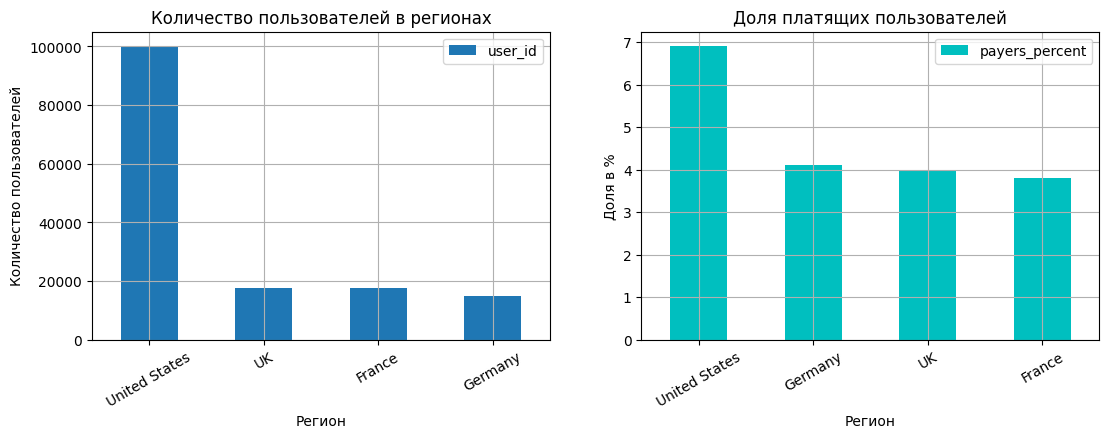

In [ ]:
plt.figure(figsize=(13, 4))

ax1 = plt.subplot(1, 2, 1)
profiles_region.sort_values(by='user_id', ascending=False).plot.bar(
                                                           x='region', y=['user_id'], grid=True,
                                                           title='Количество пользователей в регионах',
                                                           rot=30, ax=ax1).set(xlabel='Регион',
                                                                               ylabel='Количество пользователей')

ax2 = plt.subplot(1, 2, 2)
profiles_region.sort_values(by='payers_percent', ascending=False).plot.bar(
                                                             x='region', y=['payers_percent'], grid=True,
                                                             title='Доля платящих пользователей',
                                                             rot=30, color='c',ax=ax2).set(xlabel='Регион',
                                                                                           ylabel='Доля в %')

plt.show()



Больше всего пользователей - в США. Доля таких пользователей составляет 66,9%.    
Далее почти с одинаковым количеством пользователей идут Великобритания(11.72%) и Франция (11.63%) и меньше всего пользователей из Германии - 9.99%.   
Среди платящих пользователей также заметно выделяется США: почти 7% от общего количества пользователей, против 3-4% в остальных странах.    
Примечательно то, что при наименьшем количестве пользователей из Германии доля платящих пользователей в этом регионе выше, чем в Великобритании и Франции.

### Анализ пользовательских профилей с делением по используемым устройствам ###

**Выясним, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.**

In [ ]:
# сгруппируем профили пользователей по устройству, посчитаем количество пользователей,
# количество платящих пользователей и процент платящих пользователей
profiles_device = (
    profiles.groupby('device')[['user_id', 'payer']]
    .agg({'user_id': 'count', 'payer':'sum'}).reset_index()
)
profiles_device['payers_percent'] = round(profiles_device['payer'] / profiles_device['user_id'] * 100, 1)
profiles_device.sort_values(by='payers_percent', ascending=False)

device  user_id  payer  payers_percent
1      Mac    30042   1912             6.4
3   iPhone    54479   3382             6.2
0  Android    35032   2050             5.9
2       PC    30455   1537             5.0

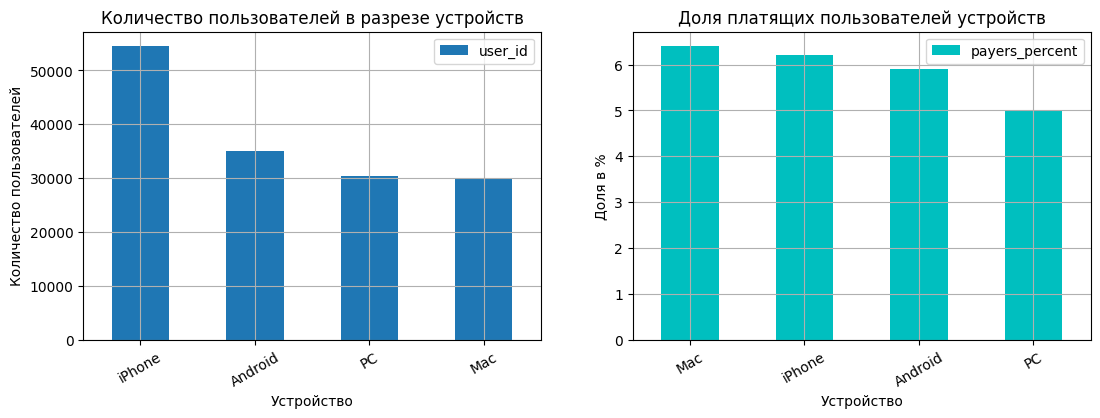

In [ ]:
# Построим таблицу, отражающую количество пользователей
# и долю платящих для каждого устройства.


plt.figure(figsize=(13, 4))

ax1 = plt.subplot(1, 2, 1)
profiles_device.sort_values(by='user_id', ascending=False).plot.bar(
                                                           x='device', y=['user_id'], grid=True,
                                                           title='Количество пользователей в разрезе устройств',
                                                           rot=30, ax=ax1).set(xlabel='Устройство',
                                                                               ylabel='Количество пользователей')

ax2 = plt.subplot(1, 2, 2)
profiles_device.sort_values(by='payers_percent', ascending=False).plot.bar(
                                                             x='device', y=['payers_percent'], grid=True,
                                                             title='Доля платящих пользователей устройств',
                                                             rot=30,color='c', ax=ax2).set(xlabel='Устройство',
                                                                                           ylabel='Доля в %')

plt.show()



Большая часть пользователей пользуется сервисом на iPhone (54479 пользователей), далее идут пользователи Android (35032) и почти в равных долях последнее место делят пользователи PC и Mac.    
Среди платящих пользователей мы наблюдаем другое распределение - первое место принадлежит пользователям Mac (6.6%), далее идут пользователи iPhone (6.21%), Andriod (5.85%) и на последнем месте - пользователи PC(5.05%)

### Анализ каналов привлечения ###

**Изучим рекламные источники привлечения
и определим каналы, из которых пришло больше всего платящих пользователей.**

In [ ]:
profiles_channel = (
    profiles.groupby('channel')[['user_id', 'payer']]
    .agg({'user_id': 'count', 'payer':'sum'}).reset_index()
)
# процент пользователей каждого канала
profiles_channel['users_percent'] = round(profiles_channel['user_id'] / profiles_channel['user_id'].sum() * 100, 1)
# процент платящих каждого канала
profiles_channel['payers_percent'] = round(profiles_channel['payer'] / profiles_channel['user_id'] * 100, 1)

profiles_channel.sort_values(by='users_percent', ascending=False)

channel  user_id  payer  users_percent  payers_percent
10             organic    56439   1160           37.6             2.1
1             FaceBoom    29144   3557           19.4            12.2
6               TipTop    19561   1878           13.0             9.6
2              LeapBob     8553    262            5.7             3.1
4   OppleCreativeMedia     8605    233            5.7             2.7
7       WahooNetBanner     8553    453            5.7             5.3
5       RocketSuperAds     4448    352            3.0             7.9
3         MediaTornado     4364    156            2.9             3.6
8              YRabbit     4312    165            2.9             3.8
0           AdNonSense     3880    440            2.6            11.3
9       lambdaMediaAds     2149    225            1.4            10.5

**Построим таблицу, отражающую количество пользователей
и долю платящих для каждого канала привлечения.**

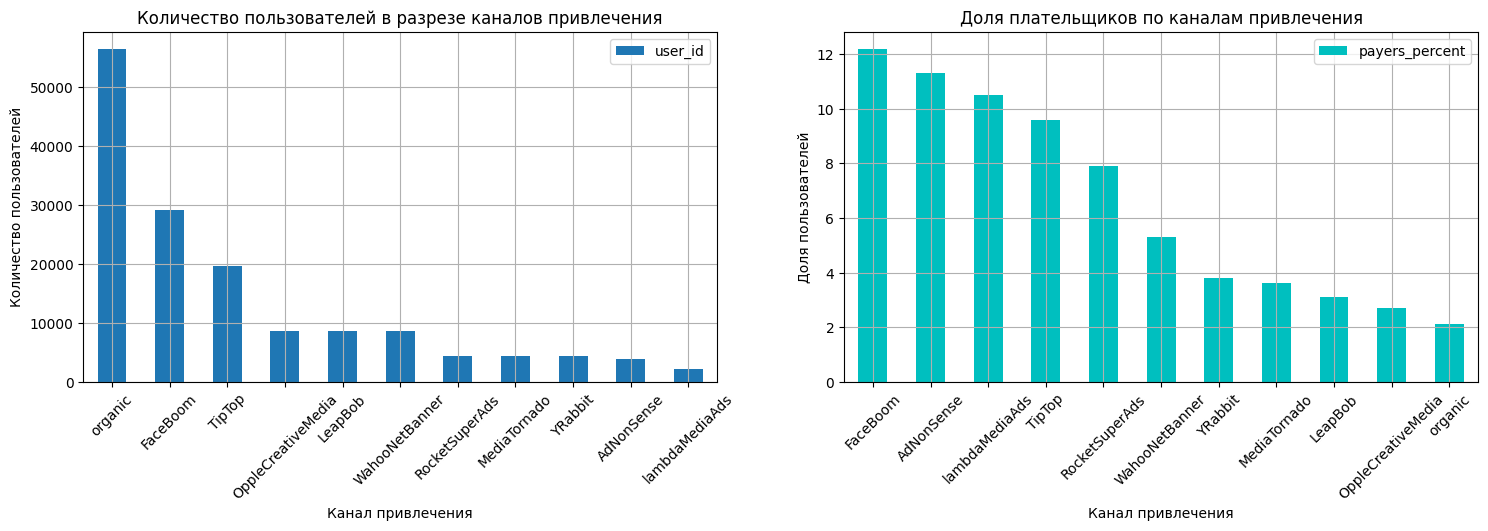

In [ ]:
plt.figure(figsize=(18, 10))

ax1 = plt.subplot(2, 2, 1)
profiles_channel.sort_values(by='user_id', ascending=False).plot.bar(
                                                           x='channel', y=['user_id'],grid=True,
                                                           title='Количество пользователей в разрезе каналов привлечения',
                                                           rot=45, ax=ax1).set(xlabel='Канал привлечения',
                                                                               ylabel='Количество пользователей')
ax2 = plt.subplot(2, 2, 2)
profiles_channel.sort_values(by='payers_percent', ascending=False).plot.bar(
                                                             x='channel', y=['payers_percent'], grid=True,
                                                             title='Доля плательщиков по каналам привлечения',
                                                             rot=45, color='c', ax=ax2).set(xlabel='Канал привлечения',
                                                                               ylabel='Доля пользователей')

plt.show()

Большинство пользователей (37.6%) находят сервис самостоятельно, но при этом среди этих пользователей самый маленький процент платящих (2.1%).
Из платных рекламных источников на первом месте FaceBoom (19.4%), и этот же источник лдитует по численности платящих пользователей (12.2%). На втором месте по привлечению пользователей - источник TipTop. Он также демнострирует хороший процент платящих пользователей (9.6%).    
Следует отдлельно отметить два канала - AdNonSense и lambdaMediaAds. При небольшой доле привлекаемых пользователей, у них одни из самых больших показателей по платящим пользователям - 11.3% и 10.5% соответственно.

### Вывод ###

Данное исследование проводилось на основе 150008 профилей пользователей с минимальной датой привлечения - 1 мая 2019 года и максимальной - 27 октября 2019 года.

Было проанализировано распеределие пользователей по регионом и установлено следующее:
- больше всего пользователей - в США. Доля таких пользователей составляет 66,9%.    
- далее идут Великобритания(11.72%) и Франция (11.63%)
- меньше всего пользователей из Германии - 9.99%.   

Среди платящих пользователей также заметно выделяется США: почти 7% от общего количества пользователей, против 3-4% в остальных странах.    
Примечательно то, что при наименьшем количестве пользователей из Германии доля платящих пользователей в этом регионе выше, чем в Великобритании и Франции.

Проанализировав распределение по используемым устройствам удалось установить следующее:
- большая часть пользователей пользуется сервисом на iPhone (54479 пользователей)
- далее идут пользователи Android (35032)
- почти в равных долях последнее место делят пользователи PC и Mac.    

Среди платящих пользователей мы наблюдаем другое распределение
- первое место принадлежит пользователям Mac (6.6%)
- далее идут пользователи iPhone (6.21%), Andriod (5.85%)
- на последнем месте - пользователи PC(5.05%)

Анализ по источникам привлечения показал следующее:
- Большинство пользователей (37.6%) находят сервис самостоятельно, но при этом среди этих пользователей самый маленький процент платящих (2.1%).
- Из платных рекламных источников на первом месте FaceBoom (19.4%), и этот же источник лдитует по численности платящих пользователей (12.2%).
- На втором месте по привлечению пользователей - источник TipTop. Он также демнострирует хороший процент платящих пользователей (9.6%).    
На графиках выделяются два канала - AdNonSense и lambdaMediaAds. При небольшой доле привлекаемых пользователей, у них одни из самых больших показателей по платящим пользователям - 11.3% и 10.5% соответственно.


## Маркетинговый анализ ##

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Выясним, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

**Посчитем общую сумму расходов на маркетинг.**

In [ ]:
print(int(costs['costs'].sum()))

105497


### Анализ распределенения трат по рекламным источникам ###

In [ ]:
profiles_costs = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs',ascending=False)
profiles_costs['percent'] =round((profiles_costs['costs'] / profiles_costs['costs'].sum())*100, 1)
profiles_costs

costs  percent
channel                              
TipTop              54751.30     51.9
FaceBoom            32445.60     30.8
WahooNetBanner       5151.00      4.9
AdNonSense           3911.25      3.7
OppleCreativeMedia   2151.25      2.0
RocketSuperAds       1833.00      1.7
LeapBob              1797.60      1.7
lambdaMediaAds       1557.60      1.5
MediaTornado          954.48      0.9
YRabbit               944.22      0.9

**Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам)
по каждому источнику.**

In [ ]:
costs['по месяцам'] = costs['dt'].astype('datetime64[M]')
costs['по неделям'] = costs['dt'].astype('datetime64[W]')
costs.head()

dt   channel  costs по месяцам по неделям
0 2019-05-01  FaceBoom  113.3 2019-05-01 2019-05-01
1 2019-05-02  FaceBoom   78.1 2019-05-02 2019-05-02
2 2019-05-03  FaceBoom   85.8 2019-05-03 2019-05-03
3 2019-05-04  FaceBoom  136.4 2019-05-04 2019-05-04
4 2019-05-05  FaceBoom  122.1 2019-05-05 2019-05-05

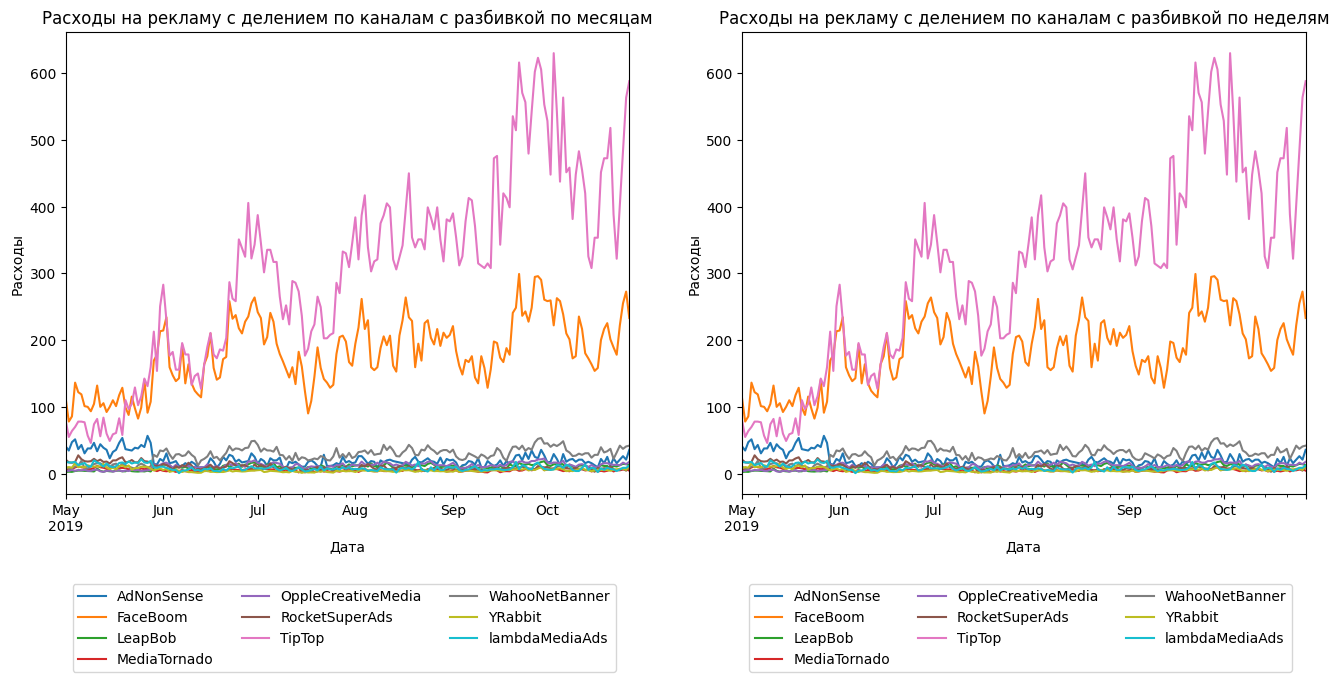

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# затраты по месяцам
(costs
 .pivot_table(
    index=costs['по месяцам'],
    values='costs',
    aggfunc='sum',
    columns='channel'
)
 .plot(ax=ax[0])
)
ax[0].set_title('Расходы на рекламу с делением по каналам с разбивкой по месяцам', loc='center')
ax[0].set_ylabel('Расходы')
ax[0].set_xlabel('Дата')
ax[0].legend(ncol=3, bbox_to_anchor=(0, -0.4), loc='lower left')


# затраты по неделям:
(costs
 .pivot_table(
    index=costs['по неделям'],
    values='costs',
    aggfunc='sum',
    columns='channel'
)
 .plot(ax=ax[1])
)

ax[1].set_title('Расходы на рекламу с делением по каналам с разбивкой по неделям', loc='center')
ax[1].set_ylabel('Расходы')
ax[1].set_xlabel('Дата')
ax[1].legend(ncol=3, bbox_to_anchor=(0, -0.4), loc='lower left')
plt.show()



Общая сумма затрат на маркетинг в период с 1 мая по 27 октября 2019 года составила 105497 долл. Больше всего средств было затрачено на канал TipTop (51.9%) и канал FaceBoom (30.8%).
Расходы на эти каналы растут, особенно на канал TipTop, пик расходов на этот канал пришелся на последнюю неделю сентября, затем несколько снизился, но этот канал всё ещё является самым затратным. Расходы на другие каналы являются достаточно стабильными и не выросли за исследуемый период.

 ### Анализ CAC из каждого источника ###

In [ ]:
mean_cost_per_channel = round(profiles.query('channel != "organic"').groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False), 2)
mean_cost_per_channel

channel
TipTop                2.80
FaceBoom              1.11
AdNonSense            1.01
lambdaMediaAds        0.72
WahooNetBanner        0.60
RocketSuperAds        0.41
OppleCreativeMedia    0.25
YRabbit               0.22
MediaTornado          0.22
LeapBob               0.21
Name: acquisition_cost, dtype: float64

In [ ]:
#round(profiles_device['payer'] / profiles_device['user_id'] * 100, 1)
round(mean_cost_per_channel.mean(), 2)

0.76

In [ ]:
round(mean_cost_per_channel.median(), 2)

0.5

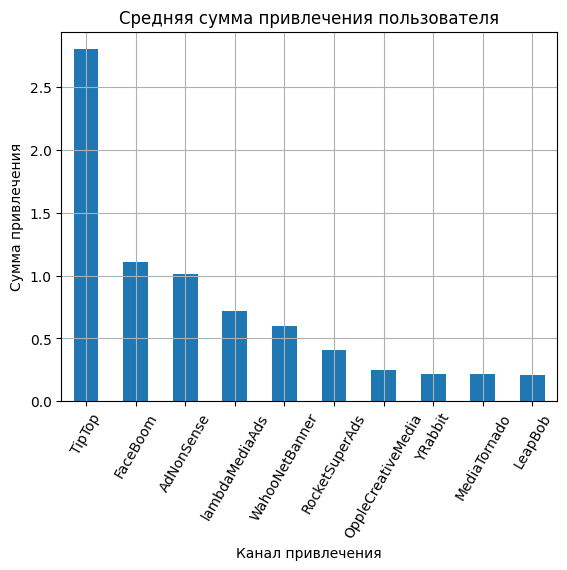

In [ ]:
mean_cost_per_channel.plot.bar(
                         grid=True, rot=60, title='Средняя сумма привлечения пользователя').set(
                         xlabel="Канал привлечения", ylabel='Сумма привлечения');

### Вывод ###
Общая сумма затрат на маркетинг в период с 1 мая по 27 октября 2019 года составила 105497 долл.
Средняя стоимость привлечения на пользователя по всему проекту - 0.76 долл.     
Больше всего средств было затрачено на канал TipTop (51.9%) и канал FaceBoom (30.8%), что в совокупности составляет больше 80% всего бюджета.    
Проанлизировав расходы в динамике по месяцам и неделям мы установили, что расходы на эти каналы росли в течение всего исследуемого периода, тогда как расходы на другие каналы являются стабильными.     
Анализ стоимости привлечения одного пользователя в каждом из каналов показал, что дорогие каналы привлечения - TipTop (2.8 долл.), FaceBoom (1.11 долл.) и AdNonSense (1.01 долл.). Канал TipTop  сильно выбивается из общей статистики и влияет на средние показатели привлечения (0.76 долл.). Если рассматривать медианное значение, оно составит 0.5 долл.

## Окупаемость рекламы ##

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам, странам и рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

**Обозначим момент и горизонт анализа**

In [ ]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

Исключим органических пользователей из анализа, чтобы исключить искажения статистики по расходам.

In [ ]:
profiles_paid = profiles.query('acquisition_cost != 0')

### Графики LTV и ROI играфики динамики LTV, CAC и ROI ###

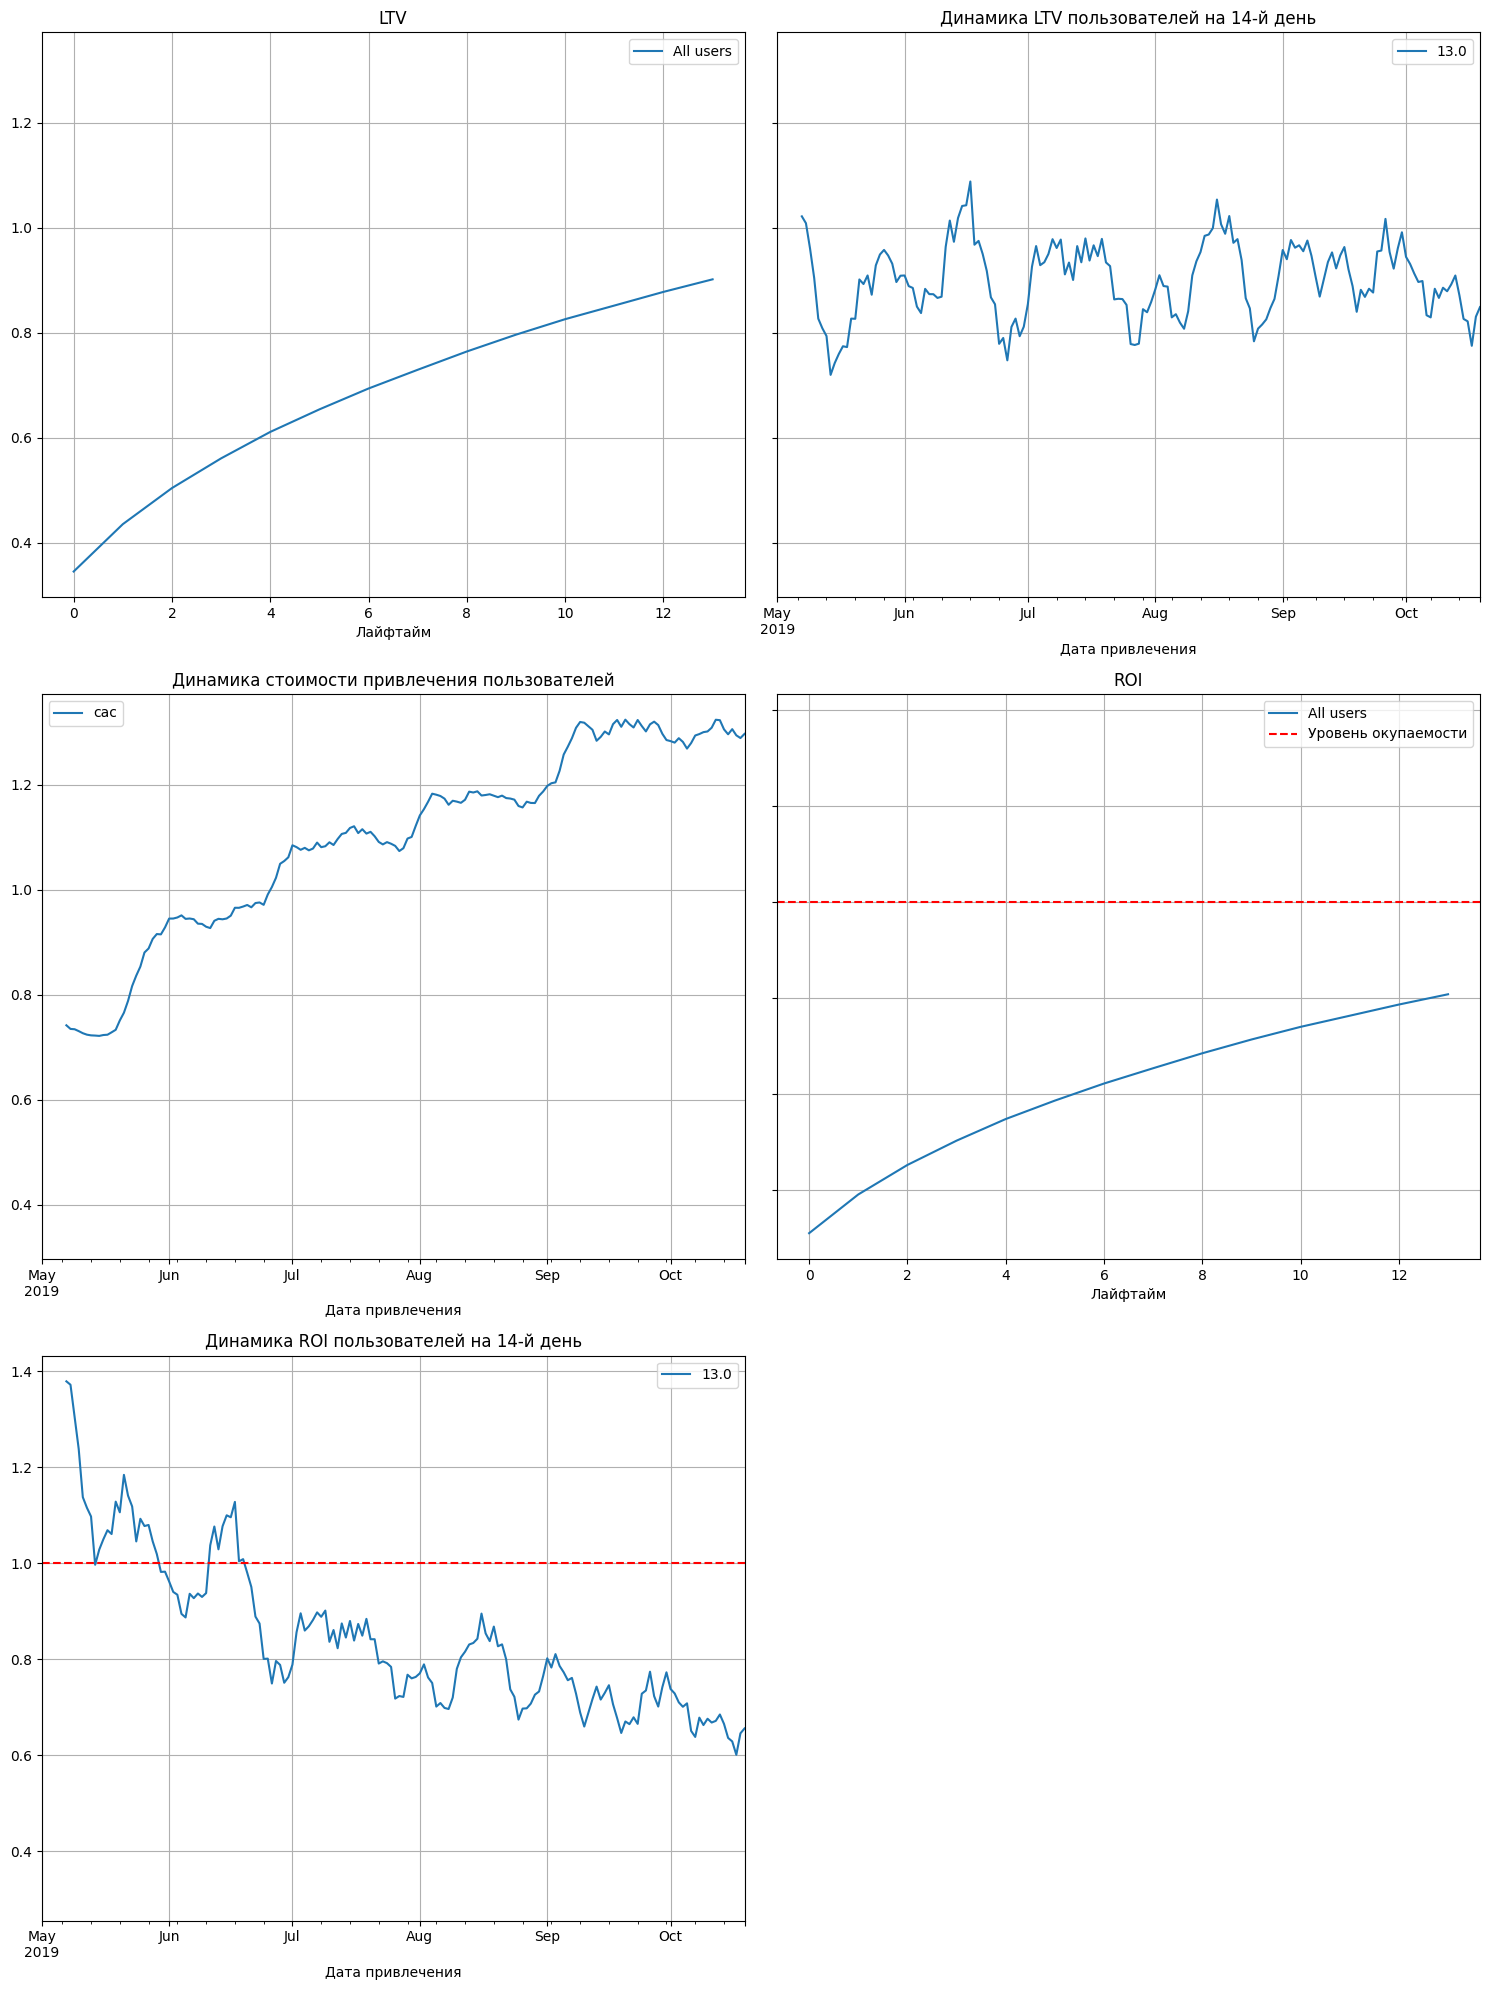

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid, orders, observation_date, horizon_days
)
# строим графики LTV и ROI
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

### Конверсия пользователей и динамика её изменения ###

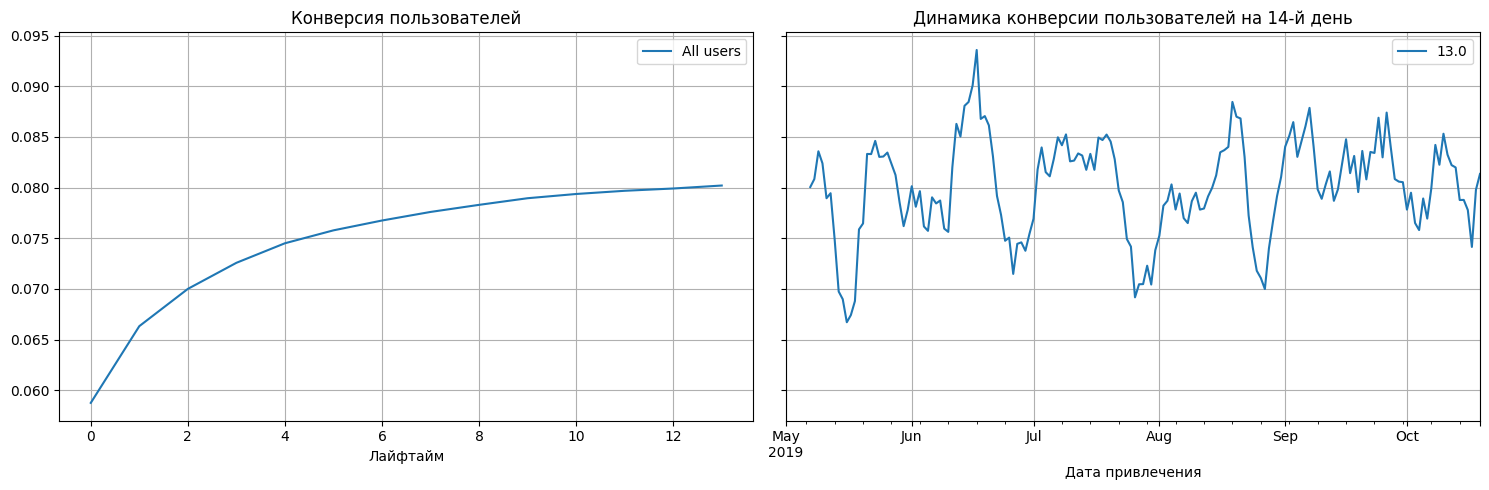

In [ ]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_paid, orders, observation_date, horizon_days, dimensions=[]
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

### Удержание пользователей и динамика его изменения ###

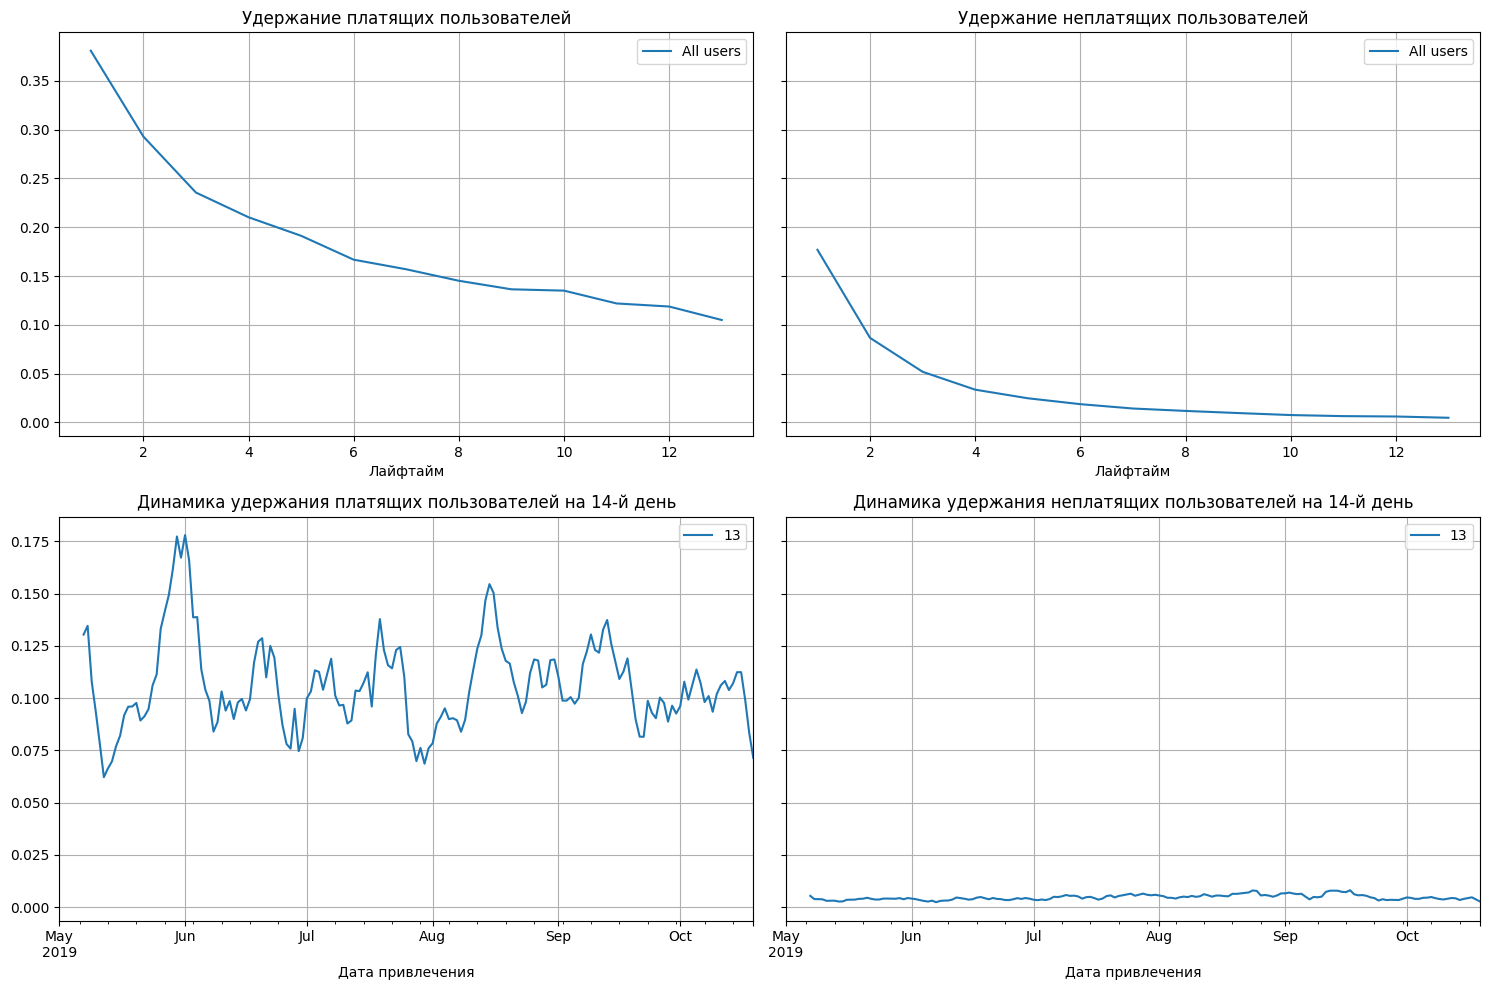

In [ ]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_paid, visits, observation_date, horizon_days, dimensions=[]
)

plot_retention(retention_grouped, retention_history, horizon_days)

На графиках LTV можно увидеть, что качество пользователей вполне удовлетворительное, показатели LTV стабильны. Тогда как стоимость привлечения пользователей растет, а коэффициент окупаемости падает. Начиная с середины июня реклама перестала окупаться и показатели продолжают падать. На момент исследования окупаемость рекламы не превышает 60%.

Чтобы разобраться в причинах, изучим данные с разбивкой по всем доступным характеристикам пользователей — устойству, стране, и рекламным каналам.

### Анализ окупаемости рекламы с разбивкой по устройствам ###

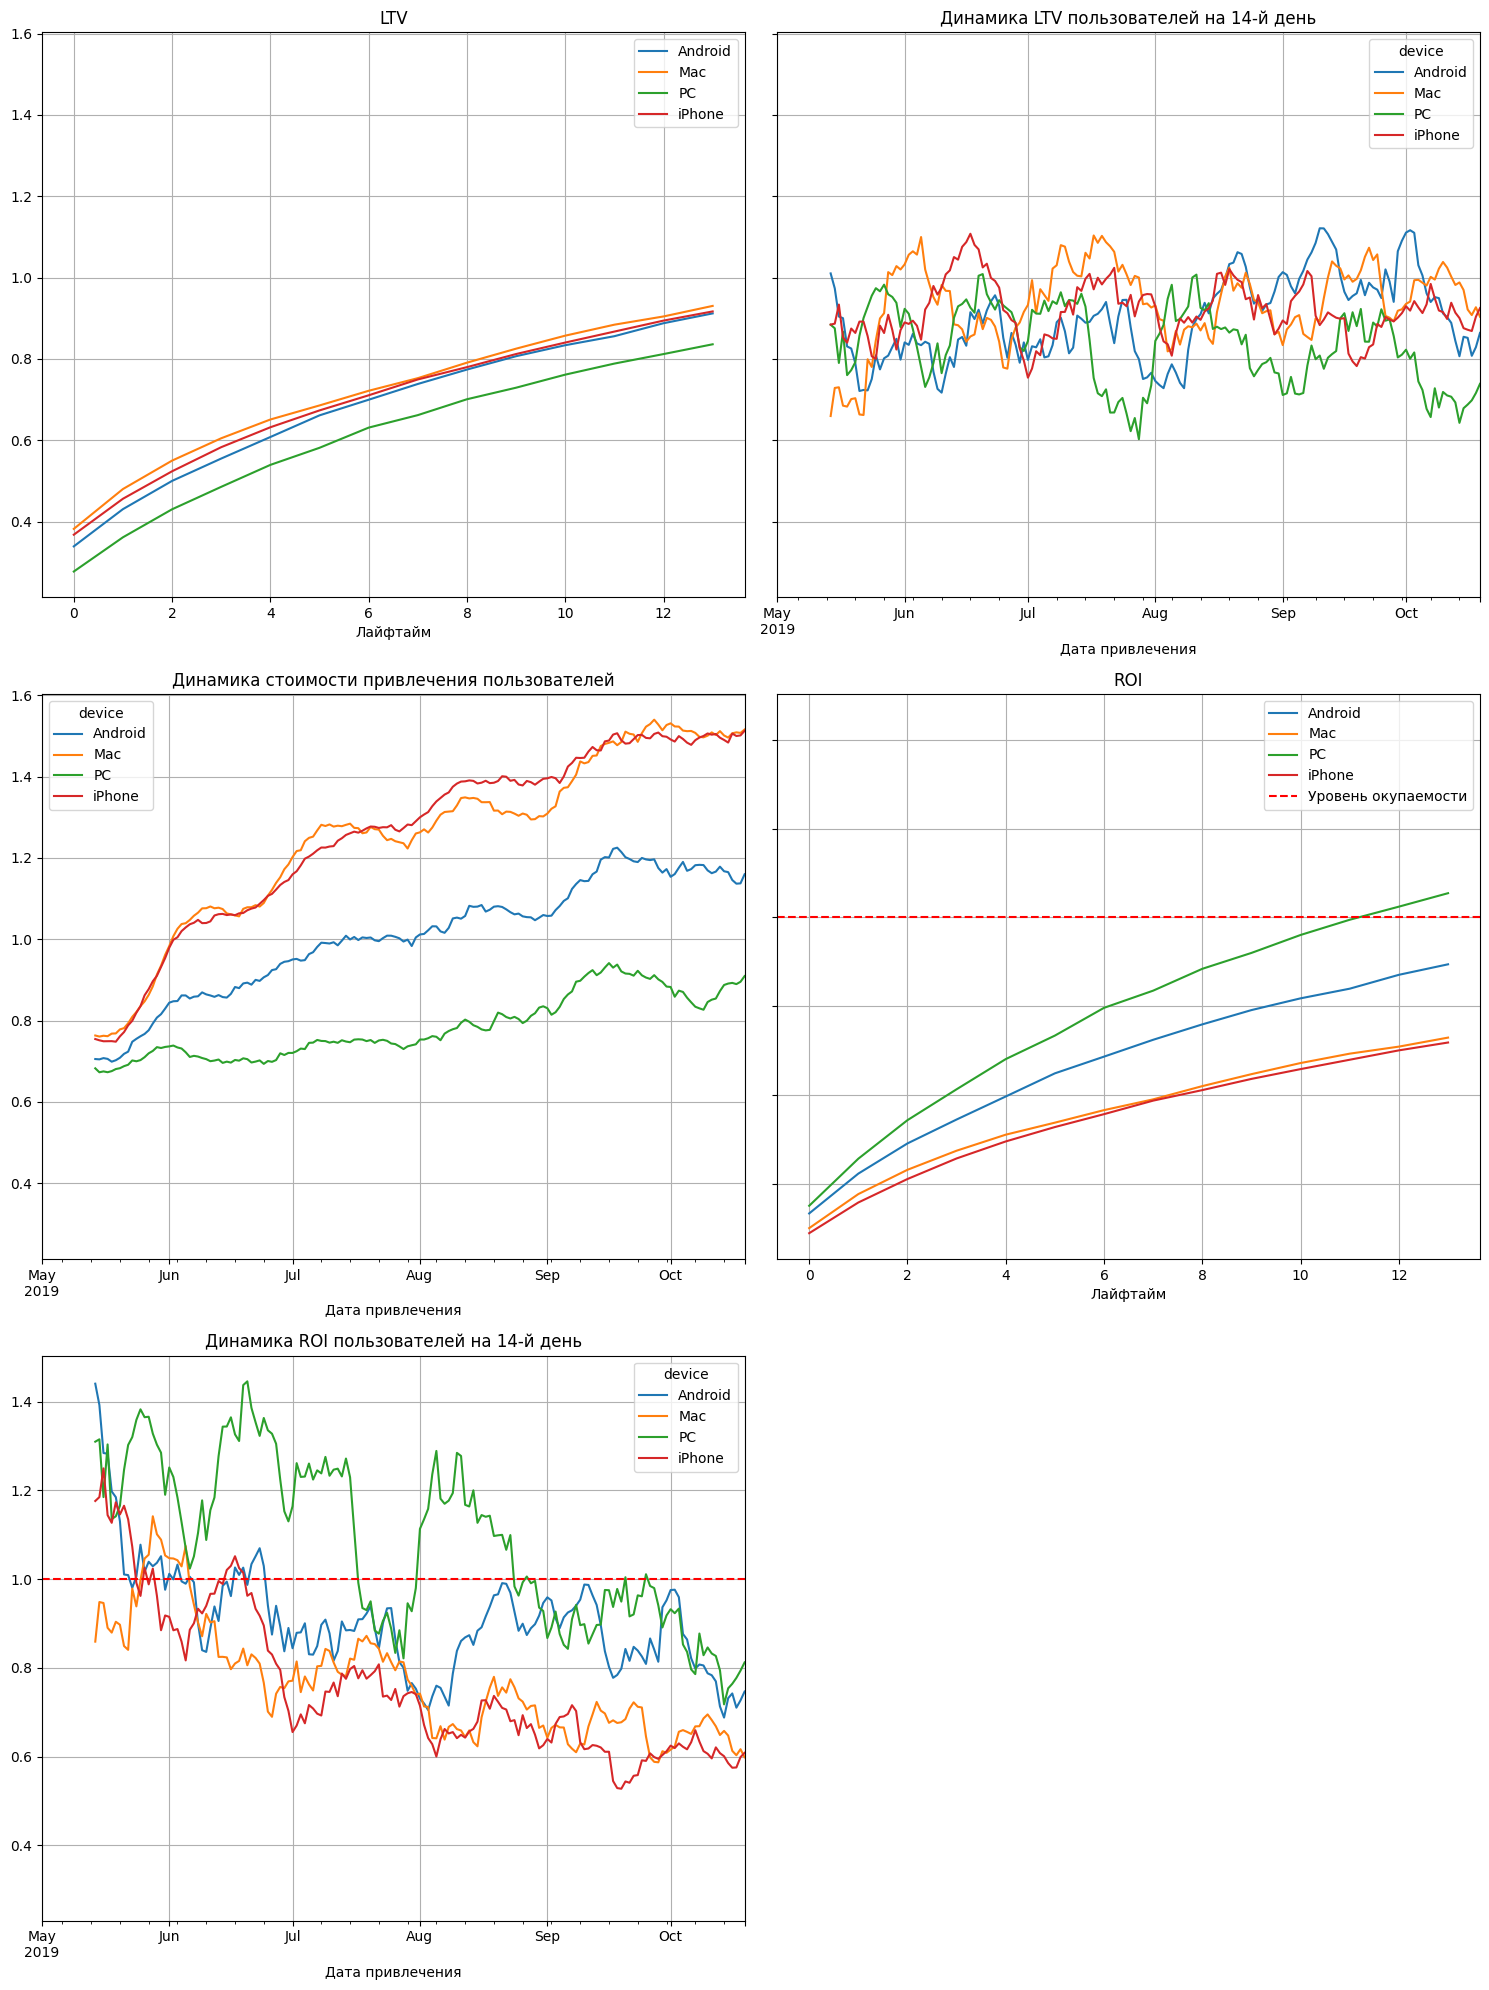

In [ ]:
 # Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

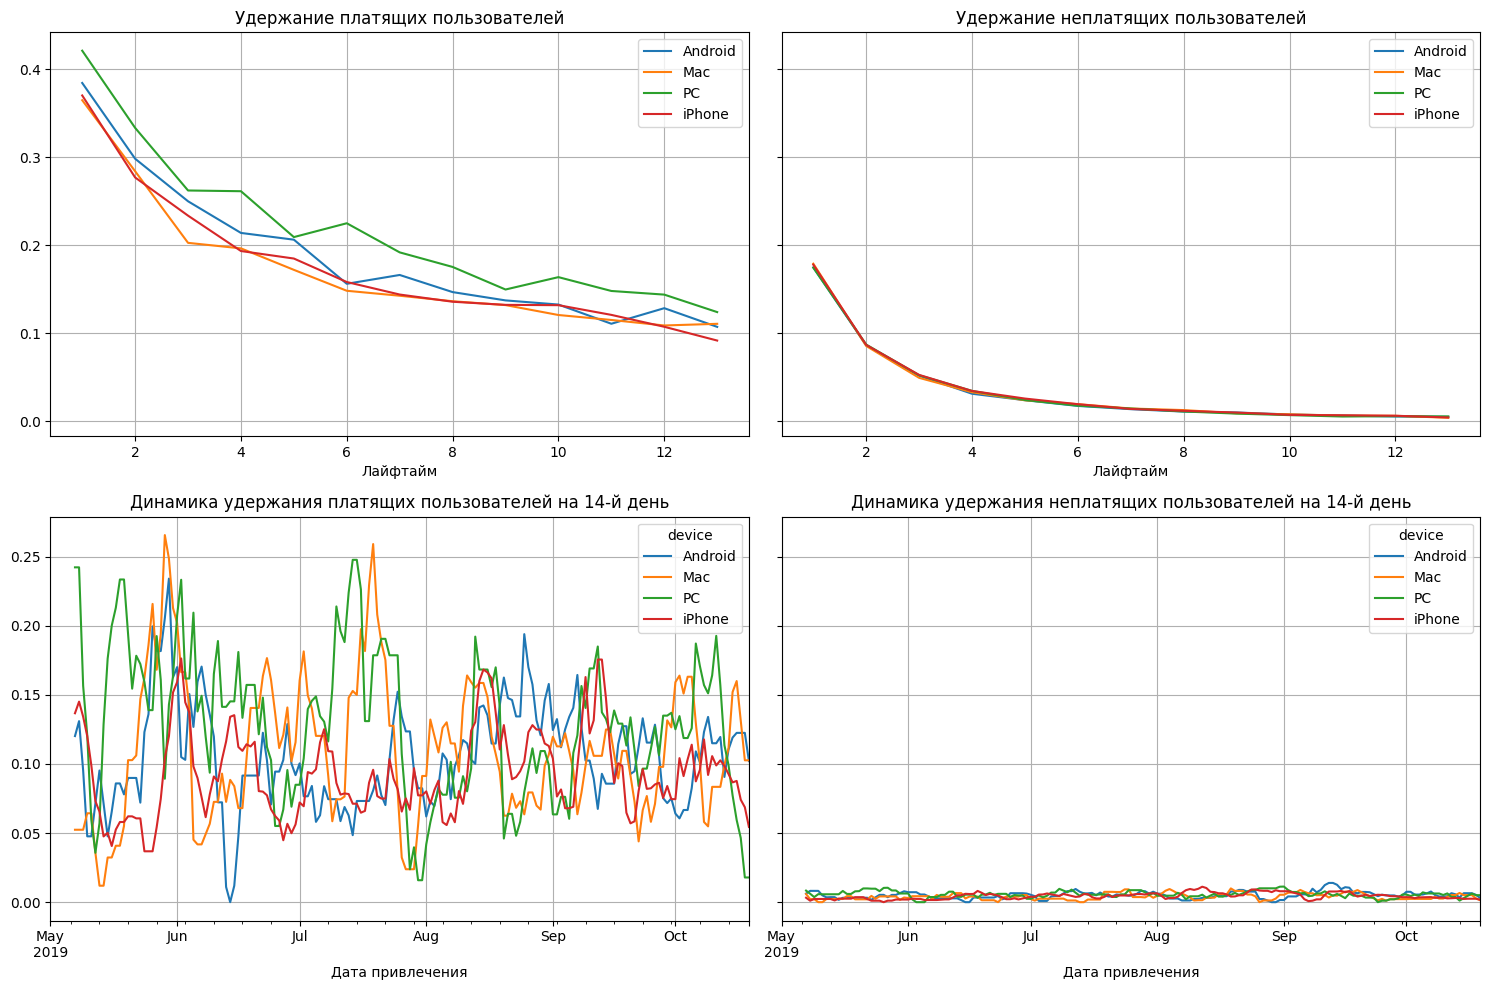

In [ ]:
# построим графики удержания с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_paid, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

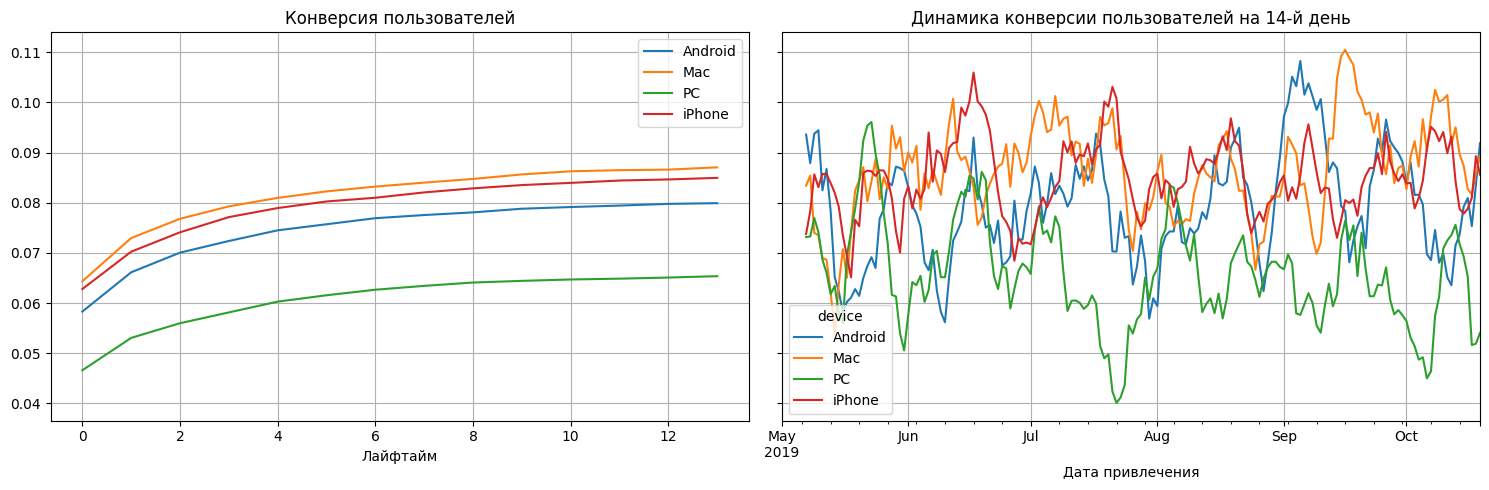

In [ ]:
# построим графики конверсии с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

У PC наблюдается наибольшая просадка по конверсии, также можно заметить "сезонные" провалы у всех устройств. Стоимость привлечения выше всего у пользователей Mac и iPhone и ниже всего у пользователей PC. Удержание незначительно выше у пользователей PC, но в целом нет каких-либо особенностей, которые бы указывали на то, что тип устройства может быть причиной низкой окупаемости.   
Можно исключить эту версию.   

### Анализ окупаемости с разбивкой по странам ###

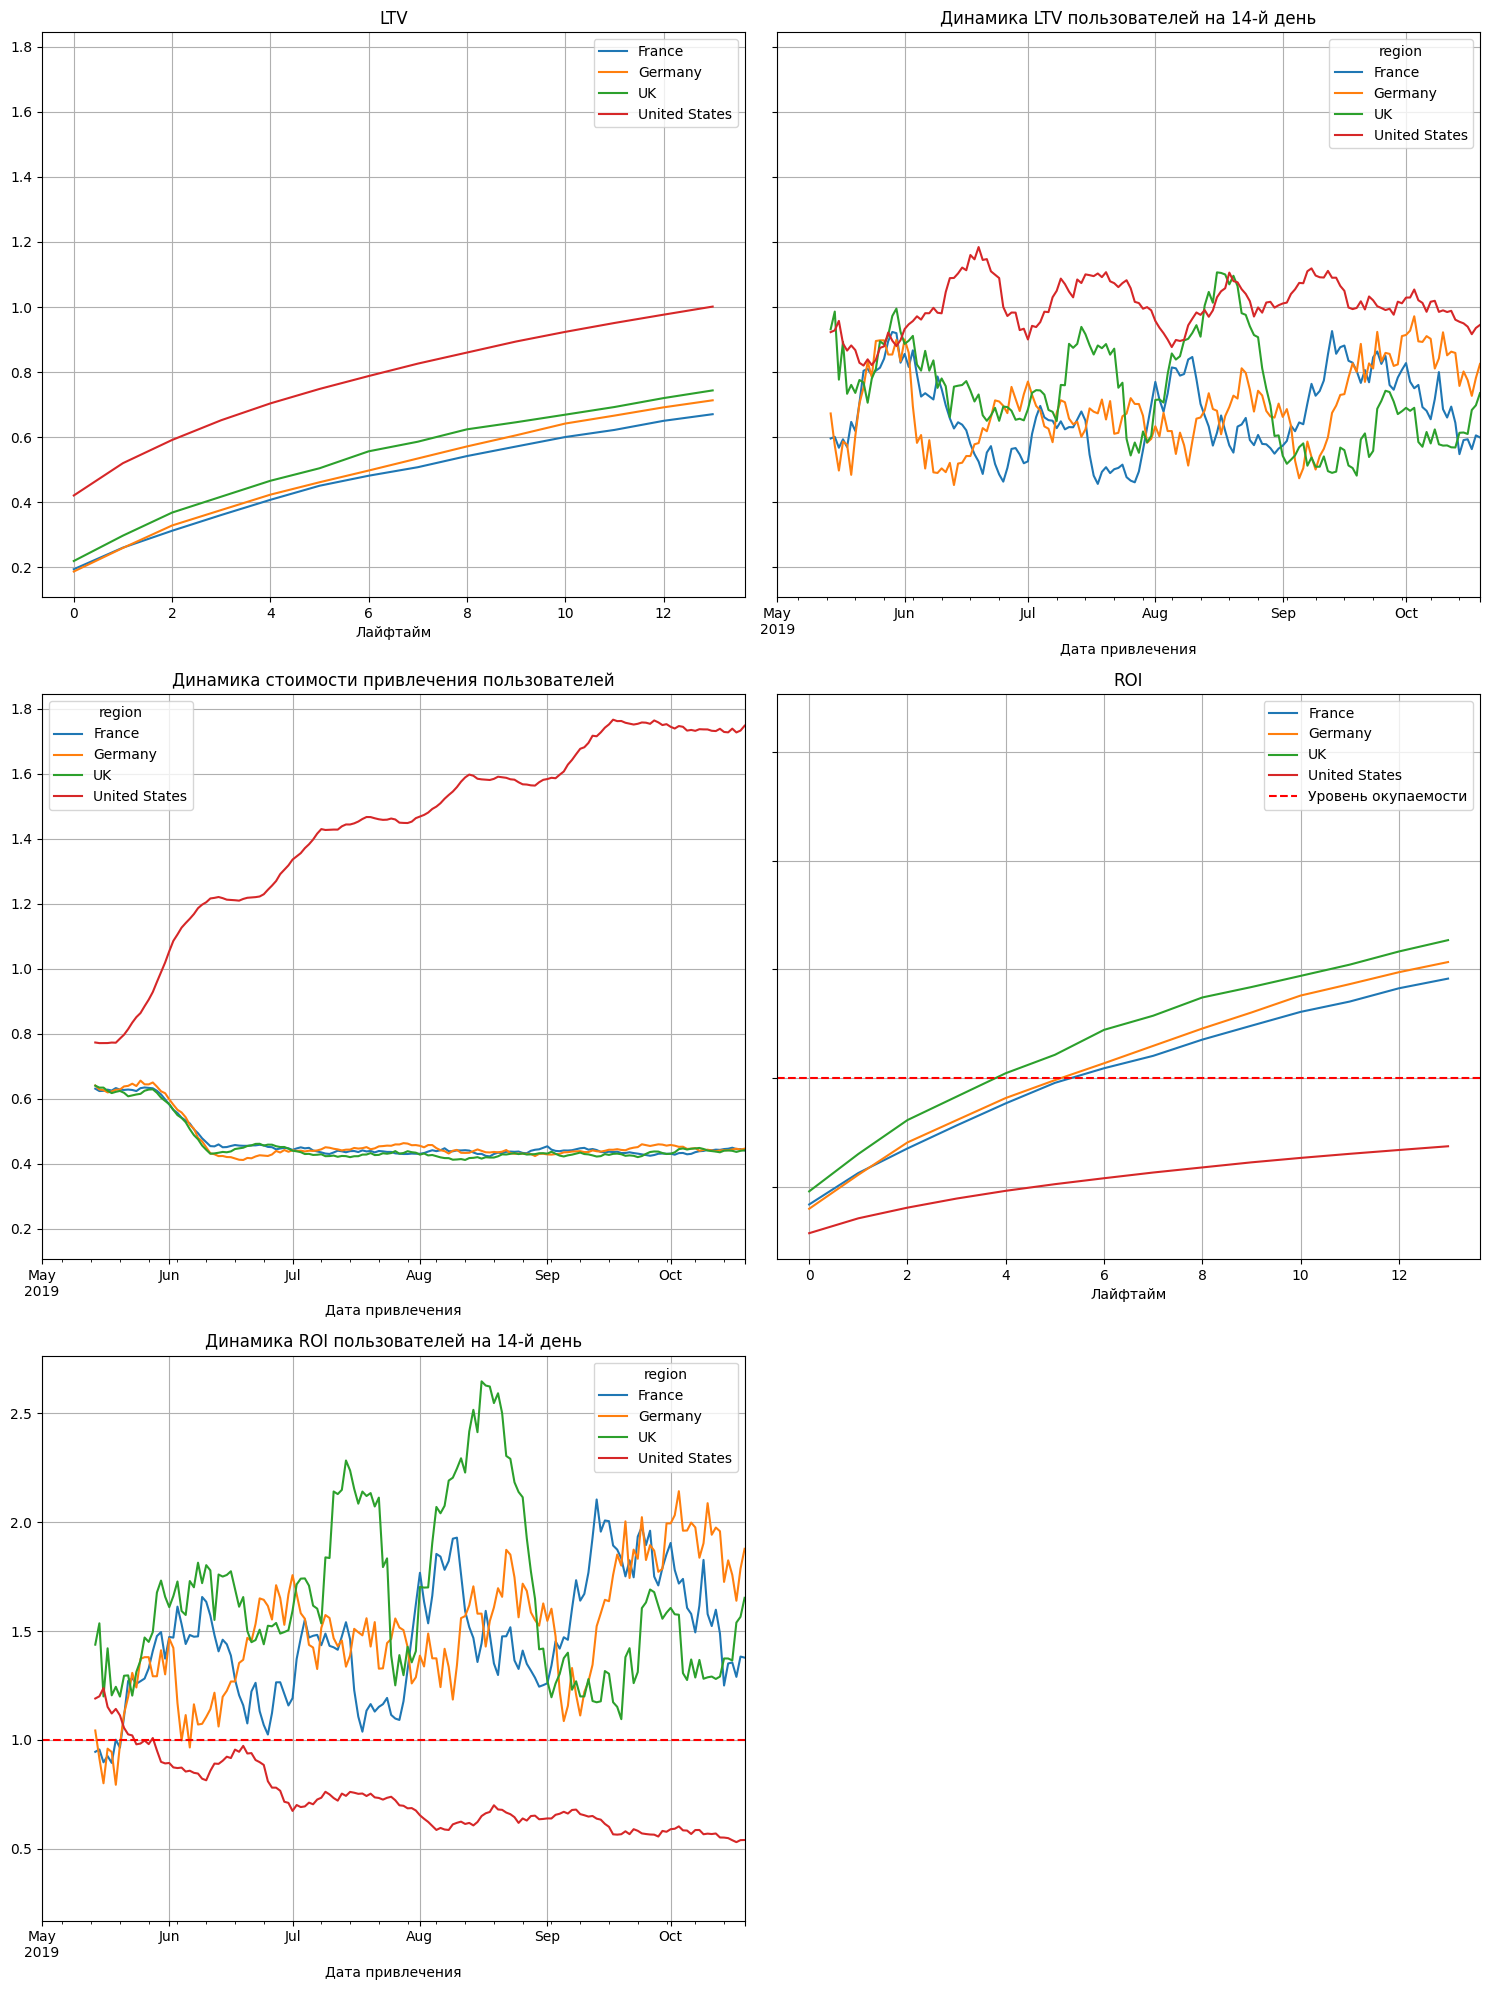

In [ ]:
# Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

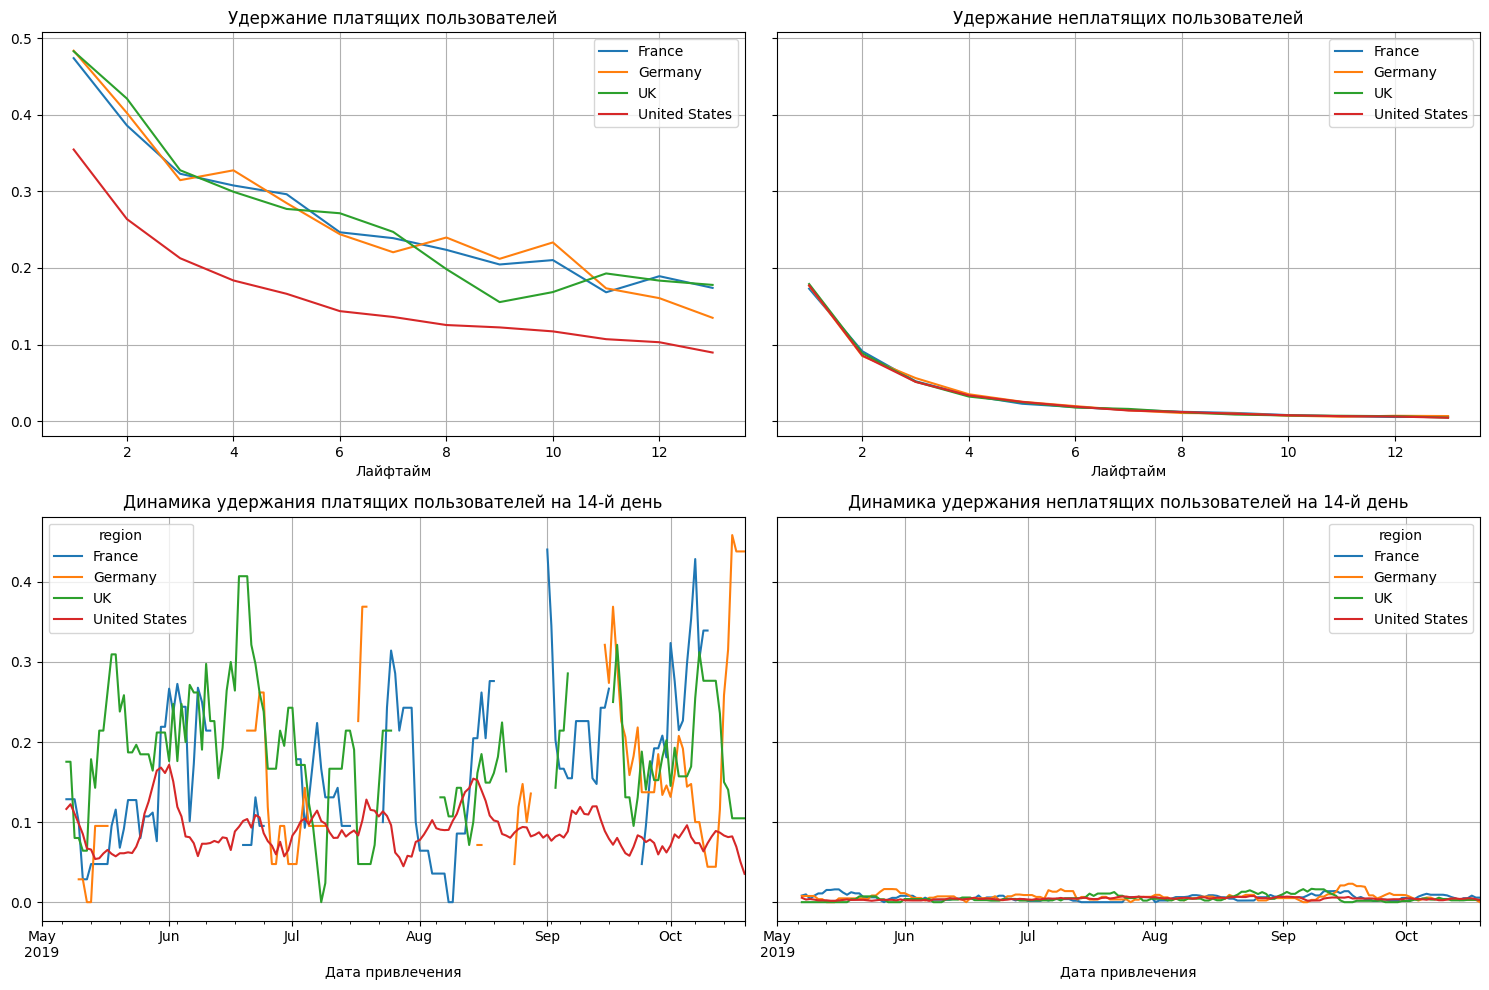

In [ ]:
# построим графики удержания с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_paid, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

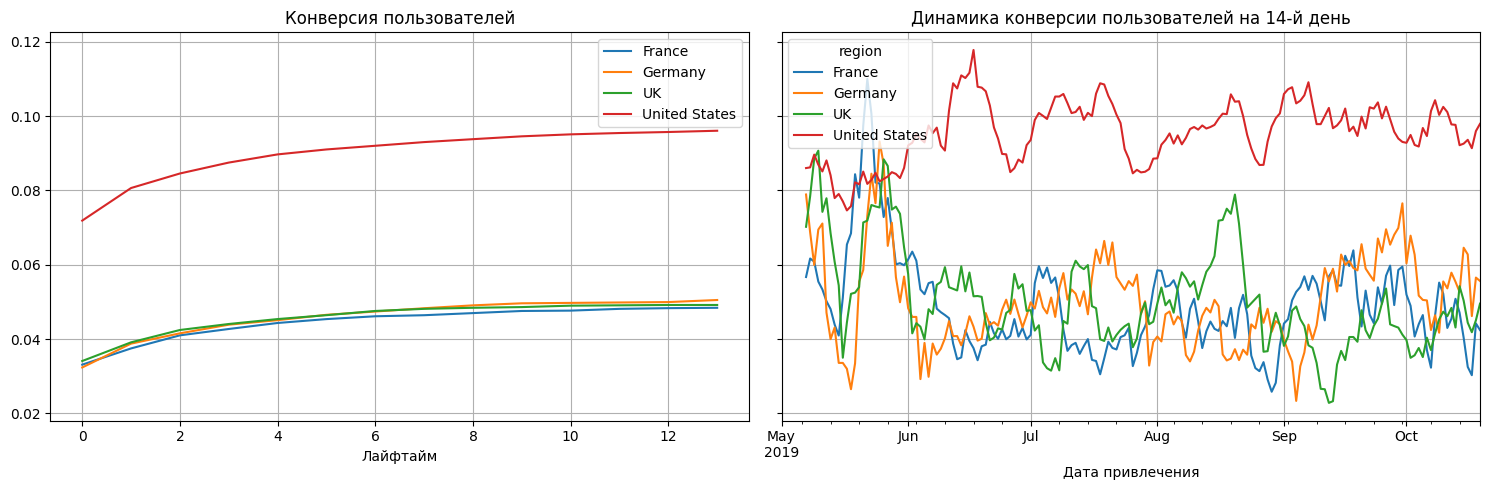

In [ ]:
# построим графики конверсии с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей США в 2 раза выше , чем в других странах, динамика конверсии на 14-й день также стабильна.    
А вот коэффициент удержания платящих пользователей из США заметно ниже, чем в других чаще всех остальных совершают целевые действия на сайте, но быстро перестают пользоваться услугами. К тому же, стоимость прислечения пользователей из США в 4,5 раза превышает стоимость прислечения пользователей из других стран, это единственная страна, в которой инвестиции затраченные на прислечение пользователей не окупаются.


### Ализ окупаемости рекламы с разбивкой по рекламным каналам ###

Так как мы выявили проблемы на рынке США, разделим данные на пользователей США и остальных пользователей и поанализируем эти данные по отдельности.

In [ ]:
#выделим профили пользователей США
profiles_usa = profiles_paid.query('region == "United States"')

In [ ]:
#выделим профили пользователей, кроме США
profiles_eur = profiles_paid.query('region != "United States"')

**Проанализируем статистику по рекламным каналам для рынка США**

In [ ]:
profiles_usa['channel'].unique()

array(['FaceBoom', 'YRabbit', 'MediaTornado', 'RocketSuperAds', 'TipTop'],
      dtype=object)

Используемые рекламные каналы в США:
- FaceBoom
- YRabbit
- MediaTornado
- RocketSuperAds
- TipTop

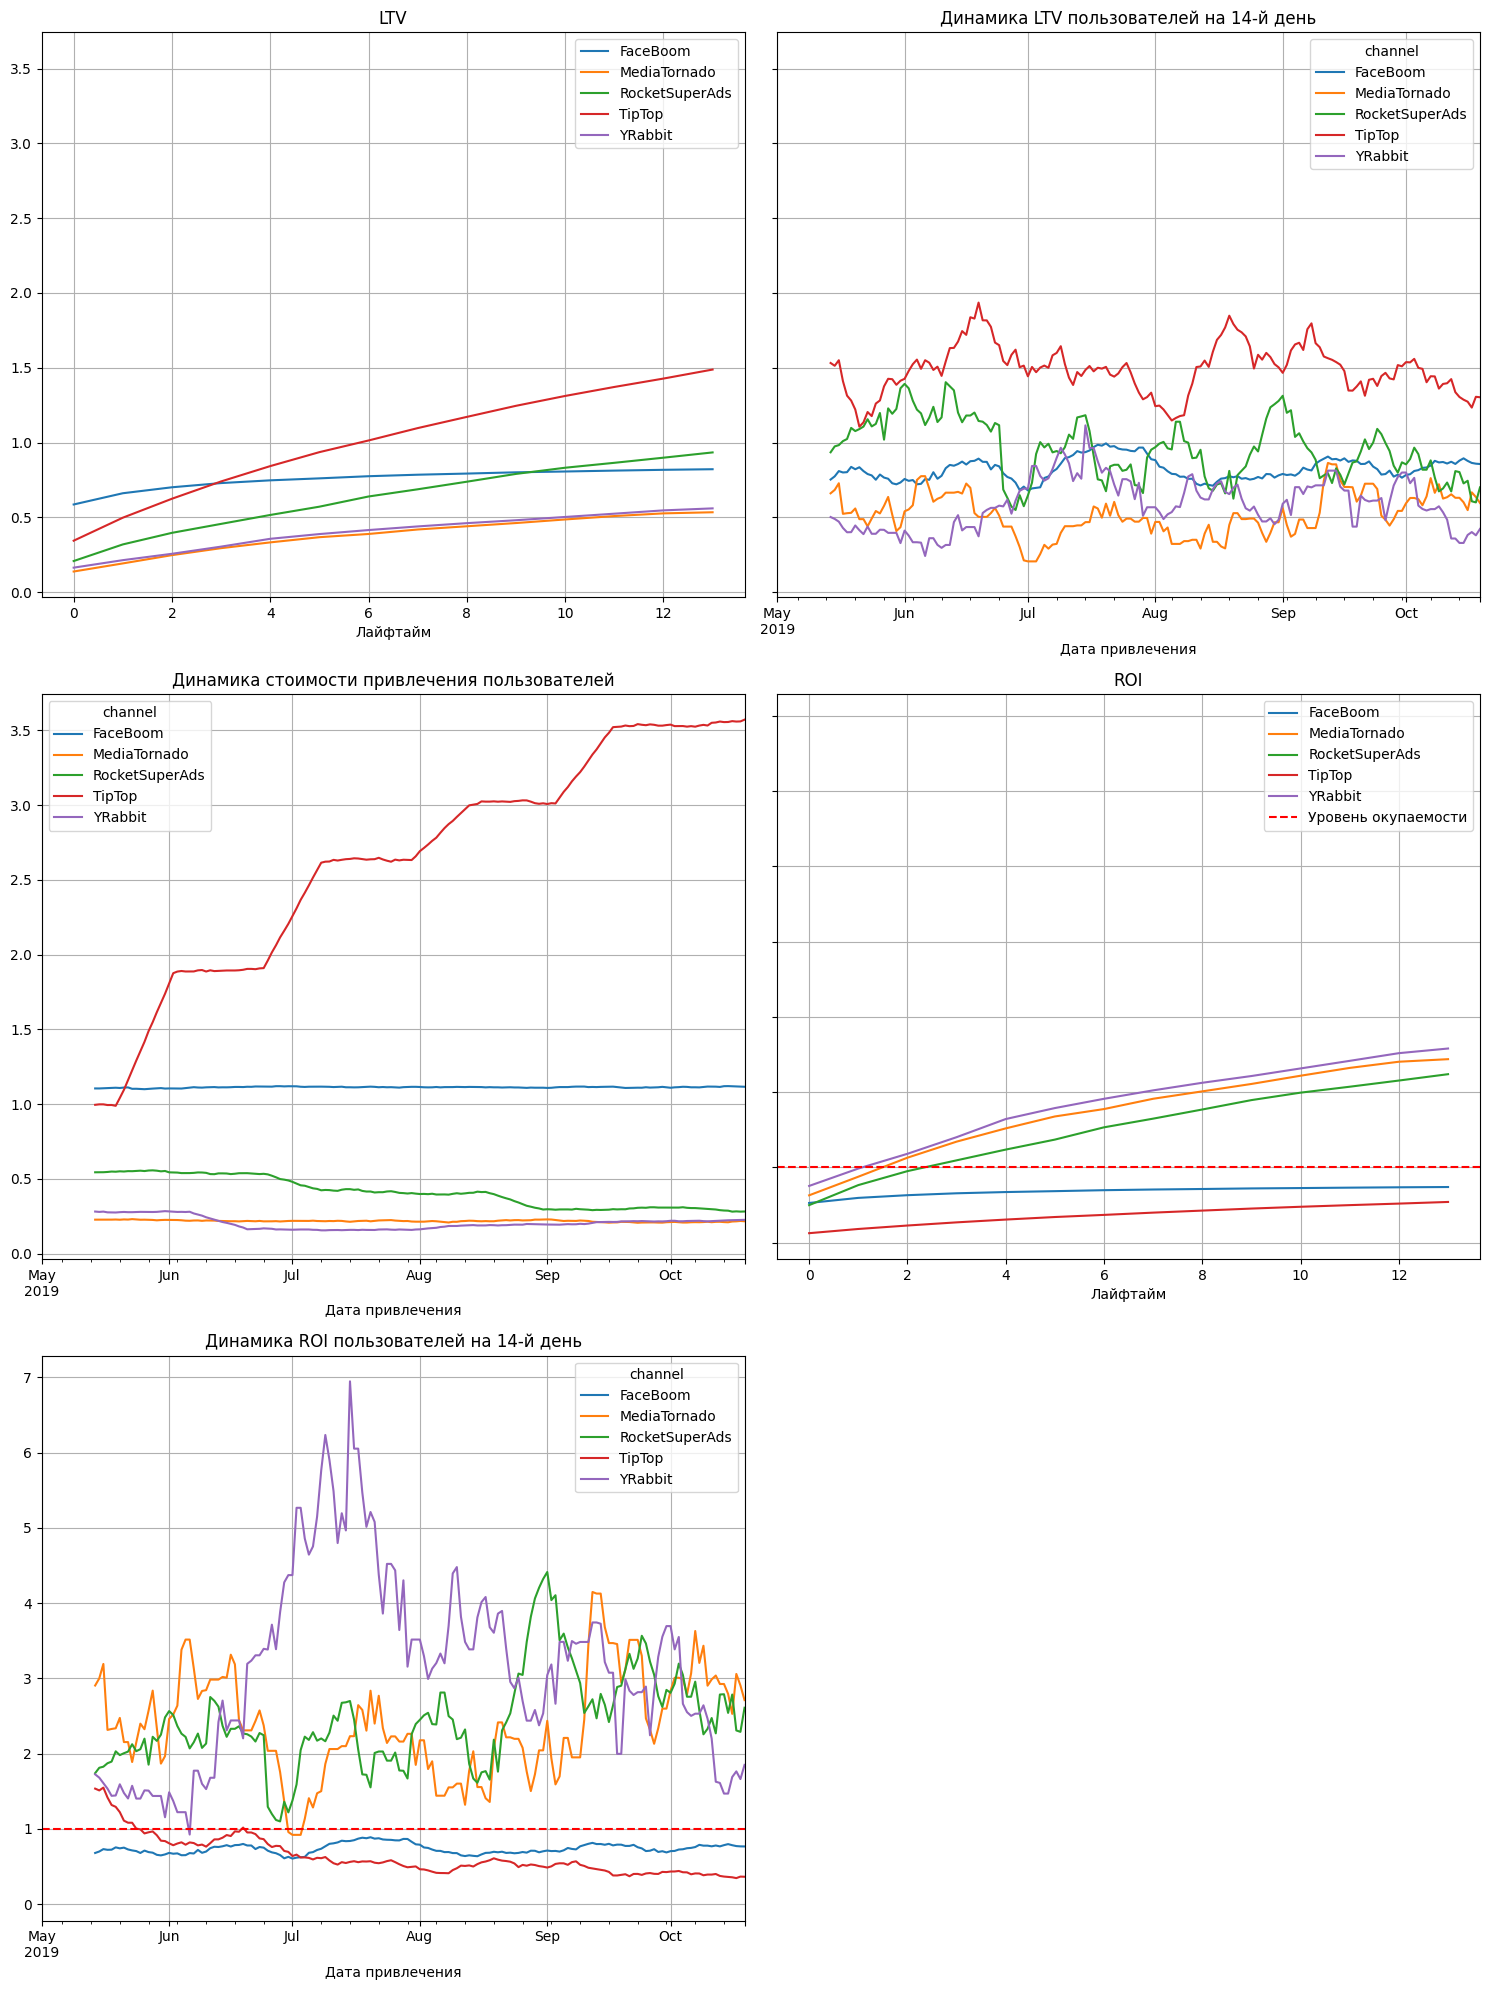

In [ ]:
 # Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI для рынка США
 dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

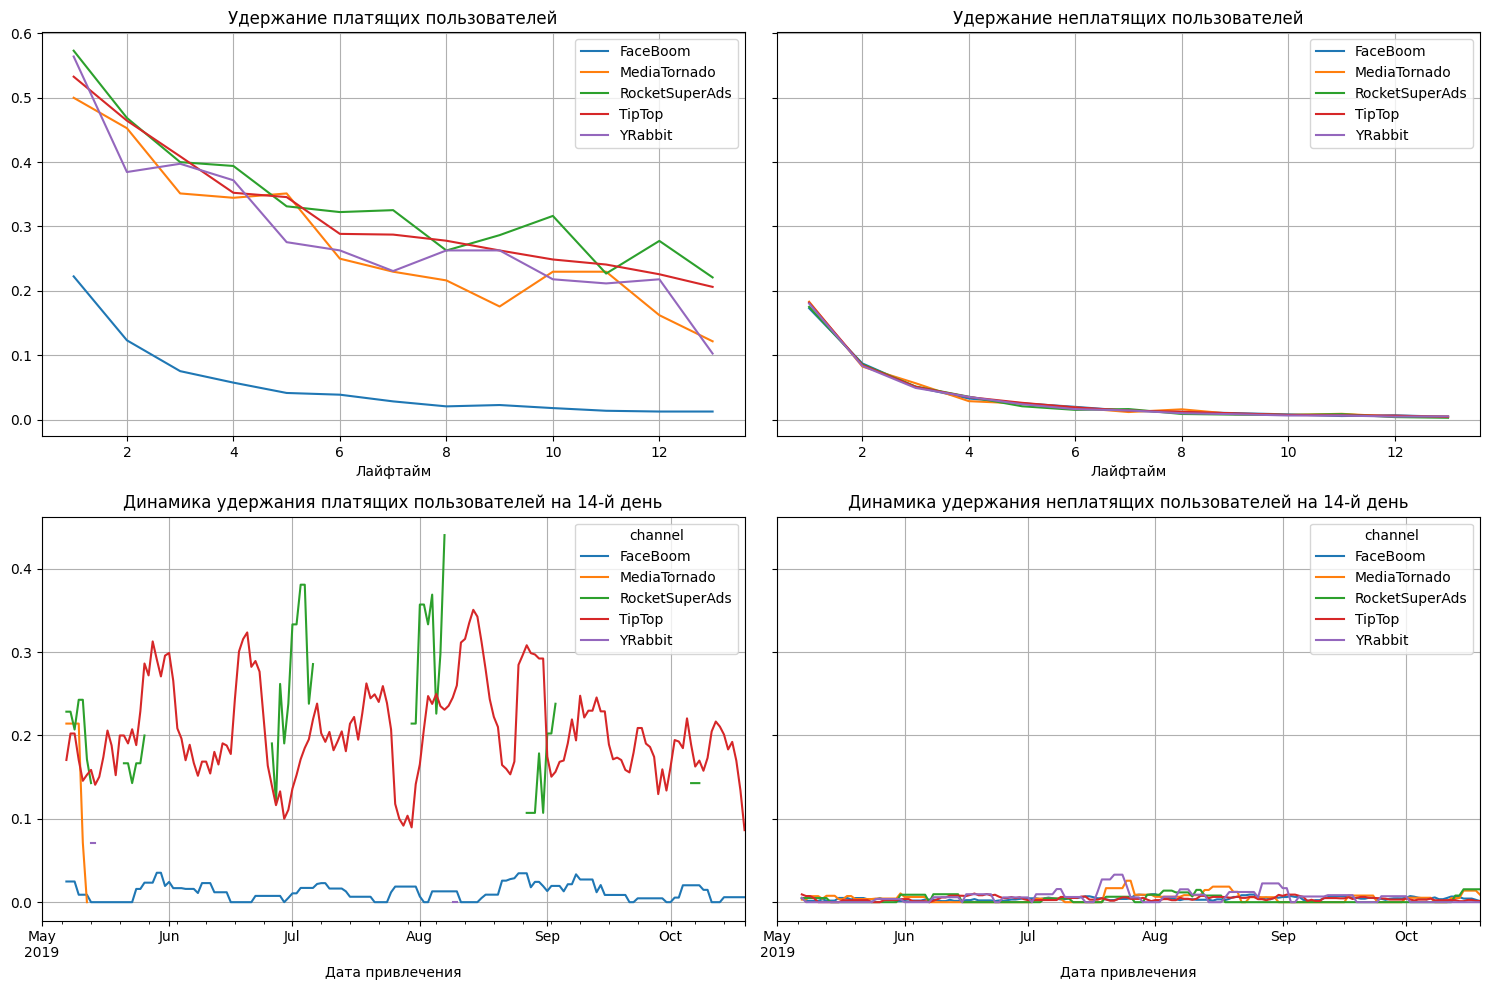

In [ ]:
# построим графики удержания с разбивкой по каналам привлечения
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

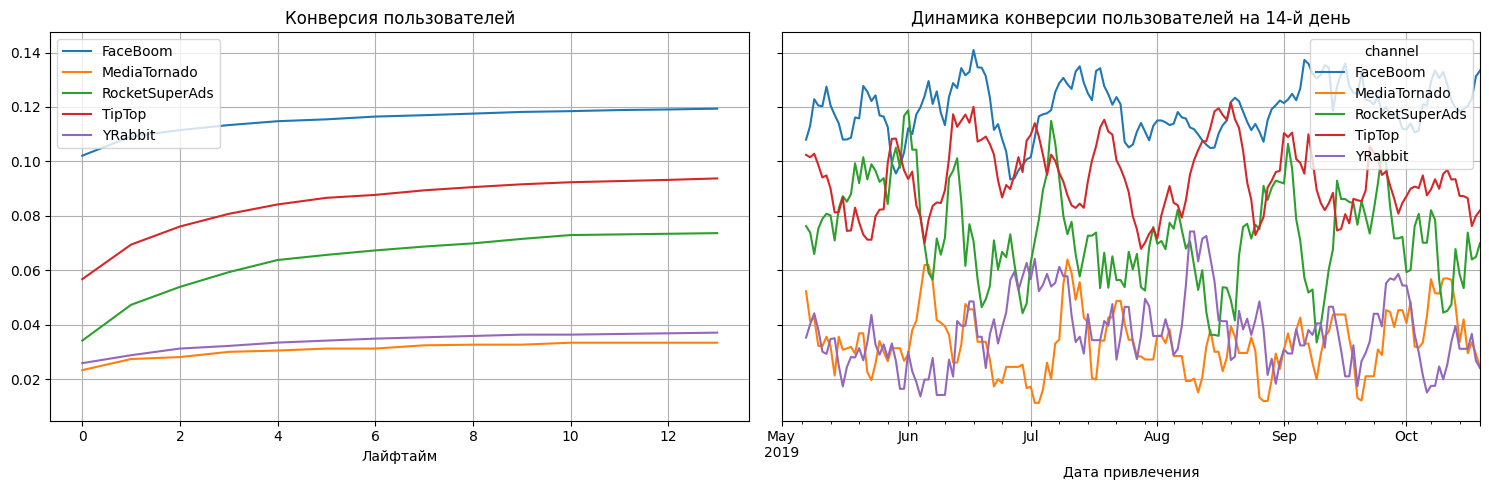

In [ ]:
# построим графики конверсии с разбивкой по каналам привлечения
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Из всех рекламных каналов американского рынка не окупаются только два - TipTop и FaceBoom.
TipTop - очень дорогой канал привлечения, цена за привлечение растет практически каждый месяц в среднем на 0.5 долл. При этом остальные показатели достаточно хорошие, в этом канале одна из лучших конверсий, по сравнению с другими каналами, Удержание у TipTop в среднем находится на общем уровне с другими каналами привлечения. Однако, несмотря на неплохие показатели, за счет чрезмерно высокой стоимости привлечения клиентов этот канал является убыточным.     
FaceBoom - второй самый дорогой канал привлечения на рынке США, однако, здесь не наблюдается роста цены привлечения, она остается стабильной. В этом канале самая высокая конверсия, по сравнению с остальными на рынке, но и самое низкое удержание. Этот фактор, наряду с высокой стоимостью прислечения делает этот канал убыточным.   
Из всех каналов выделяется RocketSuperAds, у него хорошая окупаемость, конверсия, низкая стоимость привлечения.

**Проанализируем статистику по рекламным каналам для европейского рынка**

In [ ]:
profiles_eur['channel'].unique()

array(['AdNonSense', 'LeapBob', 'WahooNetBanner', 'OppleCreativeMedia',
       'lambdaMediaAds'], dtype=object)

Используемые рекламные каналы в Европейском секторе:
- AdNonSense
- LeapBob
- WahooNetBanner
- OppleCreativeMedia
- lambdaMediaAds

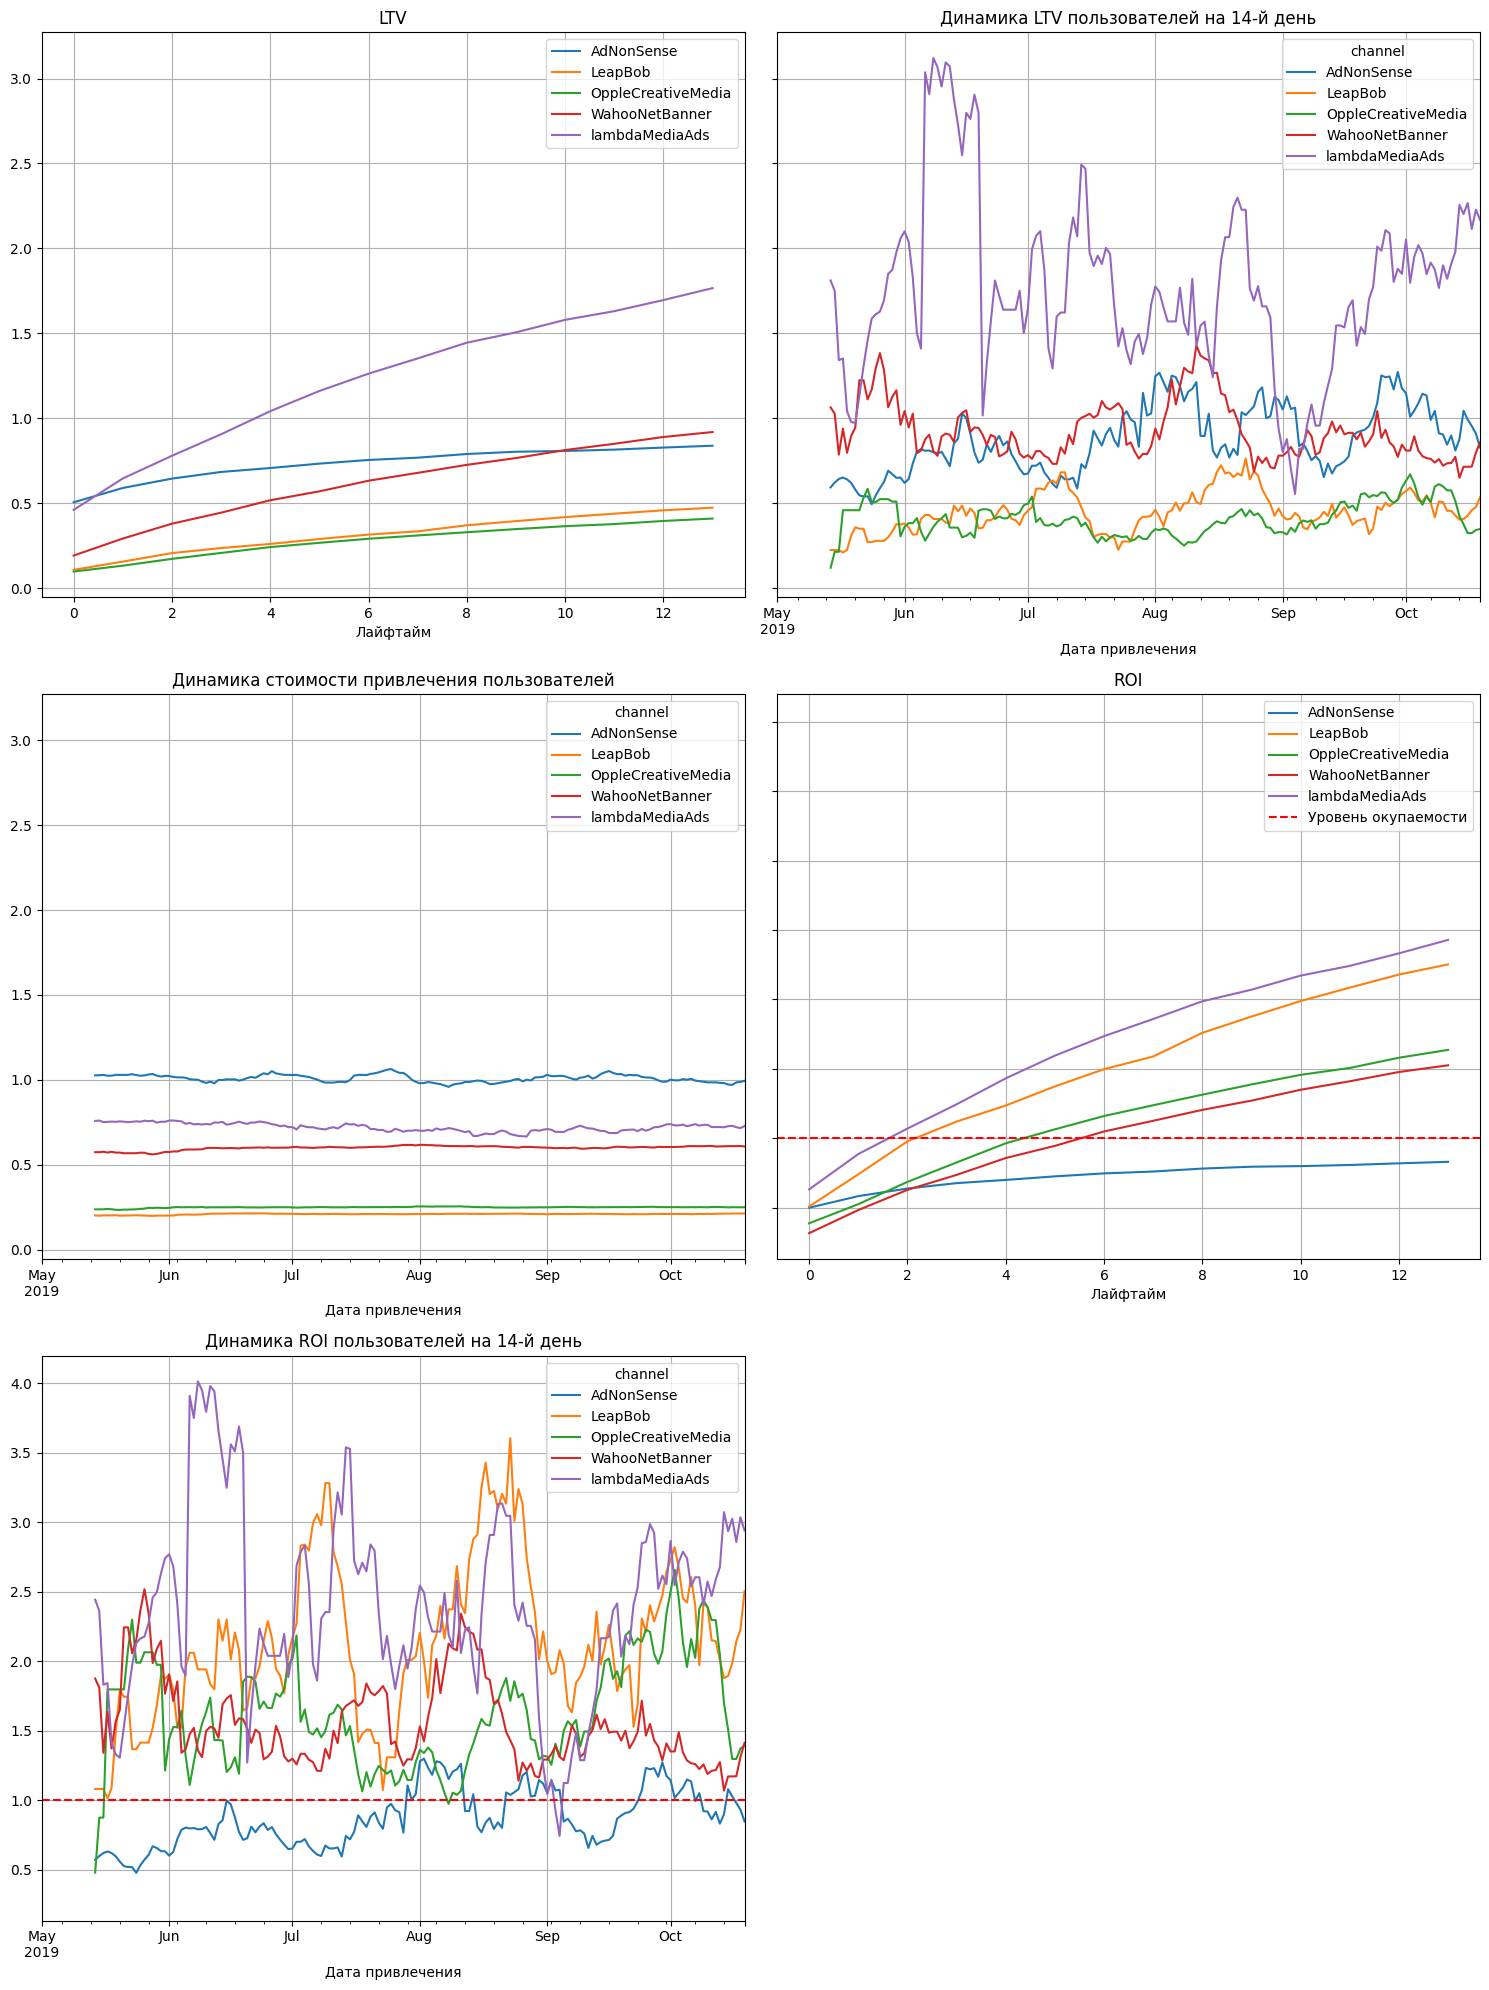

In [ ]:
 # Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI для европейского рынка
 dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_eur, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

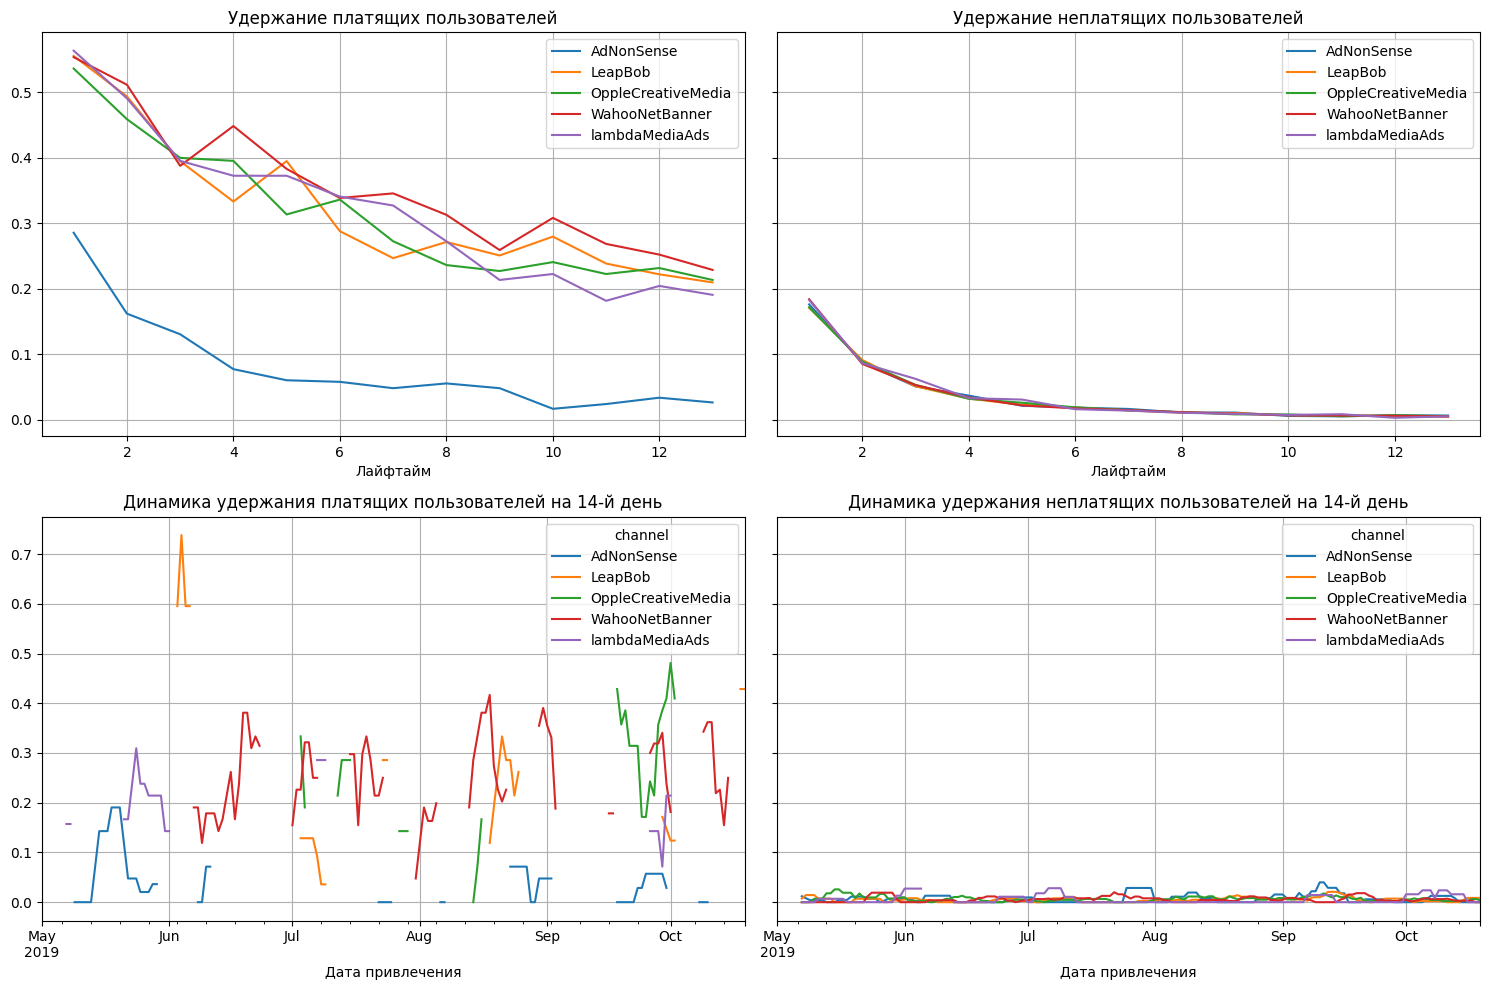

In [ ]:
# построим графики удержания с разбивкой по каналам привлечения
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_eur, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

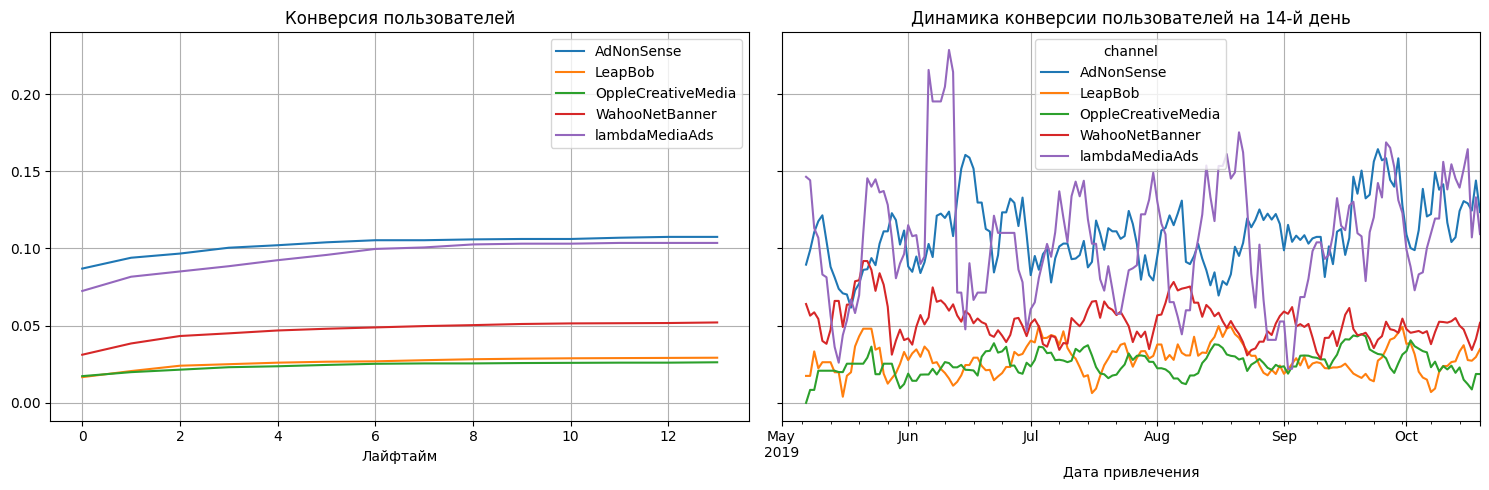

In [ ]:
# построим графики конверсии с разбивкой по каналам привлечения
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_eur, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

AdNonSence - самый дорогой канал и единственный, который не окупается. У него одна из лучших конверсий, но самый худший по рынку показатель удержания.
Стоит отметить LAmbdaMediaArts - перспективный рекламный канал с хорошей LTV динамикой, конверсией.

## Общий вывод ##
Данное исследование проводилось на основе 150008 профилей пользователей с минимальной датой привлечения - 1 мая 2019 года и максимальной - 27 октября 2019 года.

Было проанализировано распеределие пользователей по регионом и установлено следующее:

- 66,9% всех пользователей приходится на США
- далее идут Великобритания(11.72%) и Франция (11.63%)
- меньше всего пользователей из Германии - 9.99%.

Среди платящих пользователей также заметно выделяется США: почти 7% от общего количества пользователей, против 3-4% в остальных странах.
Примечательно то, что при наименьшем количестве пользователей из Германии доля платящих пользователей в этом регионе выше, чем в Великобритании и Франции.

Проанализировав распределение по используемым устройствам среди всех пользователей удалось установить следующее:

- большая часть пользователей пользуется сервисом на iPhone (54479 пользователей)
- далее идут пользователи Android (35032)
- почти в равных долях последнее место делят пользователи PC и Mac.

Среди платящих пользователей мы наблюдаем другое распределение:

- первое место принадлежит пользователям Mac (6.6%)
- далее идут пользователи iPhone (6.21%), Andriod (5.85%)
- на последнем месте - пользователи PC(5.05%)

Анализ по источникам привлечения показал следующее:

- Большинство пользователей (37.6%) находят сервис самостоятельно, но при этом среди этих пользователей самый маленький процент платящих (2.1%).
- Из платных рекламных источников на первом месте FaceBoom (19.4%), и этот же источник лдитует по численности платящих пользователей (12.2%).
- На втором месте по привлечению пользователей - источник TipTop. Он также демнострирует хороший процент платящих пользователей (9.6%).
- На графиках выделяются два канала - AdNonSense и lambdaMediaAds. При небольшой доле привлекаемых пользователей, у них одни из самых больших показателей по платящим пользователям - 11.3% и 10.5% соответственно.

Общая сумма затрат на маркетинг в период с 1 мая по 27 октября 2019 года составила 105497 долл.    
Средняя стоимость привлечения на пользователя по всем каналам - 0.76 долл.   
Больше всего средств было затрачено на канал TipTop (51.9%) и канал FaceBoom (30.8%), что в совокупности составляет больше 80% всего бюджета.    
Проанлизировав расходы в динамике по месяцам и неделям мы установили, что расходы на эти каналы росли в течение всего исследуемого периода, тогда как расходы на другие каналы являются стабильными.    
Анализ стоимость привлечения одного пользователя в каждом из каналов показал, что дорогие каналы привлечения - TipTop (2.8 долл.), FaceBoom (1.11 долл.) и AdNonSense (1.01 долл.). Канал TipTop сильно выбивается из общей статистики и влияет на средние показатели стоимости привлечения (0.76 долл.). Если рассматривать медианное значение, оно составит 0.5 долл.

Для анализа окупаемости рекламы мы проанализировали графики LTV и ROI, а также графики динамики LTV, CAC и ROI. Изучили конверсию пользователей, удержание и динамику их изменения.
На общих графиках LTV можно увидеть, что качество пользователей вполне удовлетворительное, показатели LTV стабильны. Однако, стоимость привлечения пользователей растет, а коэффициент окупаемости падает. Начиная с середины июня реклама перестала окупаться и показатели продолжают падать. На момент исследования окупаемость рекламы не превышает 60%.

Чтобы разобраться в причинах, мы изучили данные с разбивкой по всем доступным характеристикам пользователей — устойству, стране, и рекламным каналам.

Анализ с разбивкой по сутройствам показал следующее:
У PC наблюдается наибольшая просадка по конверсии, также можно заметить "сезонные" провалы у всех устройств. Но в целом нет каких-то аномальных значений и ничто не указывает, что проблема кроется в пользовании сервисом на тех или иных устройствах.   
Можно исключить эту версию.    

Анализ с разбивкой по странам:    
Конверсия пользователей США в 2 раза выше , чем в других странах, динамика конверсии на 14-й день также стабильна.    
А вот коэффициент удержания платящих пользователей из США заметно ниже, чем в других странах. То есть пользователи из США больше всех остальных совершают целевые действия на сайте, но быстро перестают пользоваться услугами.

Так как мы выявили проблемы на рынке США, для дальнейшего анализа мы разделили данные на пользователей США и остальных пользователей и поанализируем эти данные по отдельности.

Анализ с разбивкой по каналам на рыке США и европейском рынке:
Используемые рекламные каналы в США:
- FaceBoom
- YRabbit
- MediaTornado
- RocketSuperAds
- TipTop

Из всех рекламных каналов американского рынка не окупаются только два - TipTop и FaceBoom.
TipTop - очень дорогой канал привлечения, цена за привлечение растет практически каждый месяц в среднем на 0.5 долл. При этом остальные показатели достаточно хорошие, в этом канале одна из лучших конверсий, по сравнению с другими каналами, Удержание у TipTop в среднем находится на общем уровне с другими каналами привлечения. Однако, несмотря на неплохие показатели, за счет чрезмерно высокой стоимости привлечения клиентов этот канал является убыточным.     
FaceBoom - второй самый дорогой канал привлечения на рынке США, однако, здесь не наблюдается роста цены привлечения, она остается стабильной. В этом канале самая высокая конверсия, по сравнению с остальными на рынке, но и самое низкое удержание. Этот фактор, наряду с высокой стоимостью прислечения делает этот канал убыточным.  

Используемые рекламные каналы в Европейском секторе:
- AdNonSense
- LeapBob
- WahooNetBanner
- OppleCreativeMedia
- lambdaMediaAds

AdNonSence - самый дорогой канал и единственный, который не окупается. У него одна из лучших конверсий, но самый худший по рынку показатель удержания.
Стоит отметить LAmbdaMediaArts - перспективный рекламный канал с хорошей LTV динамикой, конверсией.

## Рекомендации ##
Таким обрзом, основная проблема кроется в рекламных каналах TipTop и FaceBoom на американском рынке и AdNonSence на европейском.
В случае с FaceBoom и AdNonSence основная проблема кроется в удержании. Это каналы с хорошей конверсией, но за счет плохих показателей удержания средства, затраченные на прислечение пользователя не успевают окупиться.
Необходимо найти возможные причины этого явления. Возможно, продукт, предоставляемый на платной основе, не соответствует ожиданиям пользователей, приходящих с этих каналов.
- следует обратить внимание, как именно привлекаются новы пользователи, не дается ли информация в искаженном виде и т.п.   
- рассмотреть возможность разработки программ лояльности, помогающих удерживать пользователей
- обратить внимание на перспективные каналы с хорошими показателями конверсии и удержания:    
для рынка США это каналы MediaTornado, RocketSuperAds и YRabbit    
для Европы - LAmbdaMediaArts и LeapBob